## IFN703 CIP data analysis
### R Morton, N10910603

In [5]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import datetime

import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing 
import json


import statsmodels.api
import statsmodels.formula.api as sm
import scipy.stats as stats

In [6]:
#print json objects nicely
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

### Import data

In [7]:
# assign directory
directory = 'logs'
fileList = []
# extract each log from each file
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        logList = []
        with open(f) as file:
            for jsonObj in file:
                logList.append(json.loads(jsonObj))
        fileList.append(logList)

In [8]:
#Ensure we imported 81 log files
len(fileList)

81

### Convert log files to a pandas database

In [9]:
#extract each log with a data section that isn't empty
dataList =[] 
session_ID = []
week =[]
participant = []
count = 0

for i in range(len(fileList)):
    datalist_inner = []
    session_ID_inner = []
    participant_inner = []
    for each in fileList[i]:
        try:
            if (each['ws-data']['data'] != {}):
                datalist_inner.append(each['ws-data']['data'])
                if (each['ws-data']['data']['device_order'] == 'primary'):
                    participant_inner.append(each['session-data']['participant_name'])
                    session_ID_inner.append(datetime.datetime.fromtimestamp(each['ws-data']['client_epoch']/1000))
        except KeyError:
            pass
    if (len(datalist_inner) >= 70):
        count += 1
        #print(i)
        #print(len(datalist_inner))
        #print('-----------------')
        for j in range(len(datalist_inner[:70])):
            dataList.append(datalist_inner[j])
            if datalist_inner[j]['device_order'] == 'primary':
                session_ID.append(session_ID_inner[int(j/2)])
                participant.append(participant_inner[int(j/2)])



In [10]:
#calculate start of testing minus 1 week
posix = []
for each in session_ID:
    posix.append(each.timestamp())

week_0 = min(posix) - 604800
week_ID = []
#convert unix time to weeks since start of testing
for i in range(len(posix)):
    posix[i] = posix[i] - week_0
    week_ID.append(int(posix[i]/604800))

#convert to pandas series for analysis
week_ID = pd.Series(week_ID)

In [11]:
# convert json/ dict objects to arrays, for importing to pandas dataframe

reference = []
adjustable = []
match_qual = []
fatigue = []
feedback = []
task_ID = []
task = []
trial_counter = []
participant_df =[]


for i in range(len(dataList)):


    if (dataList[i]['device_order'] == 'primary'):
        
        target_holder = 0
        try:
            #values sometimes incomplete - fill with zeroes
            match_qual.append(int(dataList[i]['feedback']['star_match_quality']))
        except KeyError:
            match_qual.append(0)
            #marker to identify empty values - all recorded!
            print(i)
        try:
            #values sometimes incomplete - fill with zeroes
            fatigue.append(int(dataList[i]['feedback']['star_fatigue']))
        except KeyError:
            fatigue.append(0)
            #marker to identify empty values - all recorded!
            print(i)
        try:
            #values sometimes incomplete - fill with zeroes
            feedback.append(dataList[i]['feedback']['txt_feedback'].strip('\n'))
        except KeyError:
            feedback.append('no feedback recorded')
            #marker to identify empty values - all recorded!
            print(i)
        task_ID.append(dataList[i]['task']['id'])
        task.append(dataList[i]['task']['type'])
        reference.append(dataList[i]['task']['target_freqs'][0])
        
        #Generate trial counter from ordering of data
        if i == 0:
            trial_counter.append(1)
            count = 1
        else:
            #check for task type change
            if dataList[i]['task']['type'] == dataList[i-2]['task']['type']:
                count += 1
                trial_counter.append(count)
            else:
                #reset counter if task type changed
                trial_counter.append(1)
                count  = 1
        #extract data based on task type
        if (dataList[i]['task']['type'] == 'pitch_matching_both_ears_desktop_speaker'):
            task_5 = [dataList[i], dataList[i+1]]
        if (dataList[i]['task']['type'] == 'pitch_matching_assess_unaided'):
            task_3 = [dataList[i], dataList[i+1]] 
            

        if ((dataList[i]['task']['type'] == 'pitch_matching_both_ears_desktop_speaker') or 
            (dataList[i]['task']['type'] == 'pitch_matching_asssess_unaided_as_control') or 
            (dataList[i]['task']['type'] == 'pitch_matching_assess_unaided')):
            for each in dataList[i]['adjustable_tone']:
                if (each['event'] == 'set_pitch'):
                    try:
                        target_holder = each['to_freq']
                    except KeyError:
                        print('keyerror')
                        continue
        else:
            for each in dataList[i + 1]['adjustable_tone']:
                if (each['event'] == 'set_pitch'):
                    try:
                        target_holder = each['to_freq']
                    except KeyError:
                        print('keyerror')
                        continue
            
        adjustable.append(target_holder)

In [12]:
#create the dataframe
df = pd.DataFrame()
df['task name'] = task
df['trial_counter'] = trial_counter
df['ref_tone'] = reference
df['participant'] = participant
df['ref_tone_log'] = np.log(reference)
df['adj_tone'] =adjustable
df['adj_tone_log'] = np.log(adjustable)
df['rated_quality'] = match_qual
df['fatigue'] = fatigue
df['feedback'] =feedback
df['time'] = session_ID
df['week'] = week_ID
df['taskID'] = df['task name'].map({'pitch_matching_double_aided':1,
                                    'pitch_matching_assess_aided':2,
                                    'pitch_matching_assess_unaided':3,
                                    'pitch_matching_asssess_unaided_as_control':4,
                                    'pitch_matching_both_ears_desktop_speaker':5})
df['offset_log'] = df['adj_tone_log'] - df['ref_tone_log'] 
#replace with 0
#df.replace(float('-inf'),0,inplace = True)
#remove
df = df[df['adj_tone_log']!= float('-inf')]

C:\Users\morto\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\morto\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


### Recreate original results - generate graph

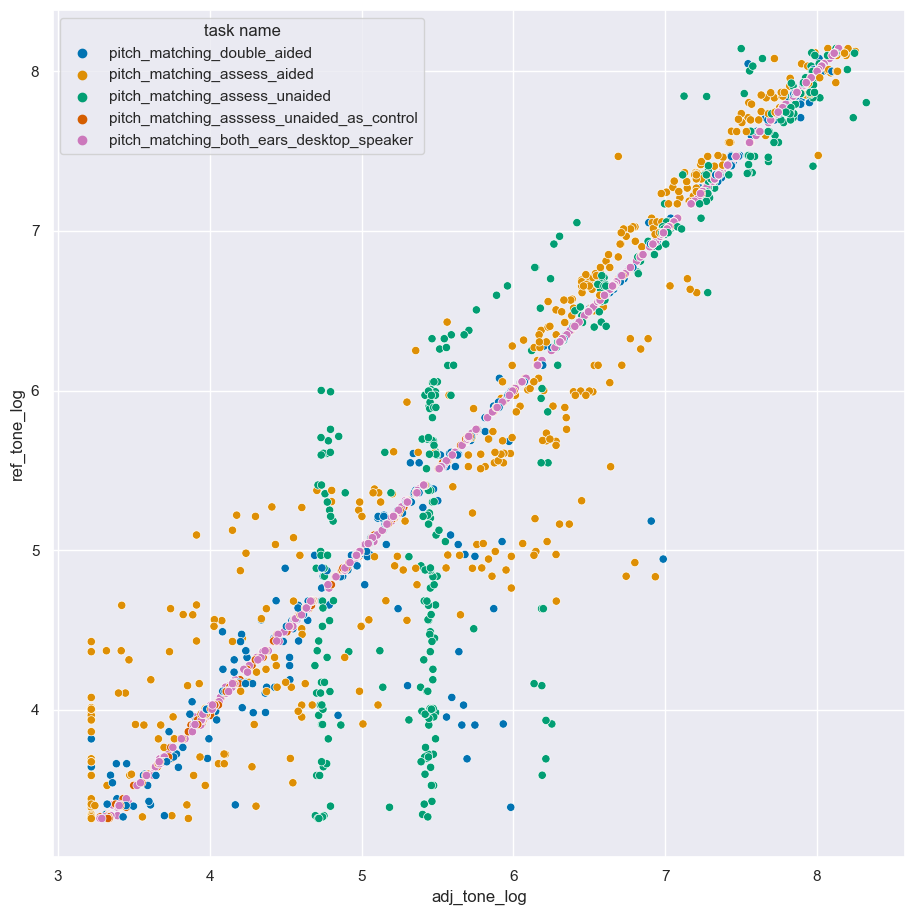

In [13]:
sns.set(rc={'figure.figsize':(11,11)})
sns.set_palette("colorblind")
#sns.set_title('Reference tone v adjustable tone')
sns.scatterplot(data=df, x="adj_tone_log", y="ref_tone_log", hue="task name")
plt.savefig('plot.png')
plt.show()

### Investigate variance by week

In [14]:
weeks_df = []
for i in range(1,10,1):
    weeks_df.append(df[df['week'] == i])

In [15]:
#an outer list of the 5 tasks, each containing 9 inner series corresponding to each week
variances = []

#for each task....
for i in range(1,6,1):
    var = []
    #for each weekly dataframe...
    for data in weeks_df:
        dummy = data[data['taskID'] == i]
        var_holder = pd.Series((dummy['adj_tone_log'] - dummy['ref_tone_log']))
        var.append(pd.Series(var_holder.var()))
    variances.append(var)

In [16]:
for i in range(len(variances)):
    for j in range(len(variances[i])):
        variances[i][j] = variances[i][j][0]

In [17]:
variance_table = pd.DataFrame(data = variances).transpose().rename((lambda a : a + 1), axis = 1).rename((lambda a : a + 1))
variance_table

,1,2,3,4,5
1,0.427292,0.255580,0.626396,0.000177,0.000205
2,0.131343,0.164130,0.699003,0.000071,0.000128
3,0.076006,0.123893,0.443568,0.000090,0.000072
4,0.006206,0.410523,0.562742,0.000075,0.000086
5,0.027158,0.225446,0.532463,0.000085,0.000143
6,0.009933,0.190170,0.517008,0.000074,0.000047
7,0.002617,0.277192,0.482295,0.000136,0.000070
8,0.001877,0.271640,0.396651,0.000063,0.000154
9,0.001586,0.233192,0.365195,0.000024,0.000014


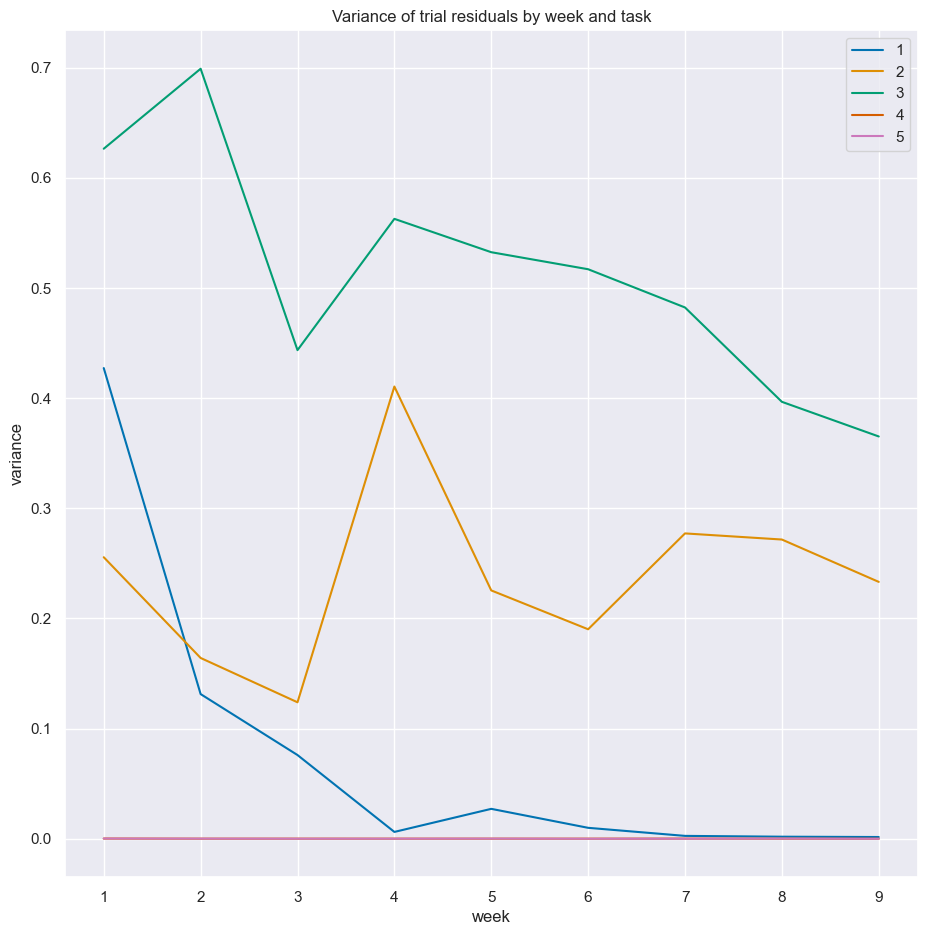

In [18]:
ax = variance_table.plot.line()
ax.set_title('Variance of trial residuals by week and task')
ax.set_xlabel('week')
ax.set_ylabel('variance')
plt.savefig('rezzies.png')
plt.show()

## Simple Linear Regression - Model 1

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression


def reg_model_sklearn(df):
    X = np.array(df['adj_tone_log'])
    y = np.array(df['ref_tone_log'])
    X = X.reshape(-1,1)
    y = y.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    print('score: ' + str(reg.score(X, y)))
    print('coefficient: ' +str(reg.coef_))
    print('intercept: ' + str(reg.intercept_))
    
    
    #create basic scatterplot
    plt.plot(X, y, 'o')

    #obtain m (slope) and b(intercept) of linear regression line
    m = reg.coef_
    b = reg.intercept_

    #add linear regression line to scatterplot 
    plt.plot(X, m*X+b)
    plt.show()
    return reg

In [20]:
def reg_model(df):
    
    #print('---------------')
    #print()
    #print('MODEL ' + str(i))
    #print()
    #print('---------------')

    model = sm.ols(formula="adj_tone_log ~ ref_tone_log", data=df).fit()
    print(model.params)
    print(model.summary())
    f = statsmodels.api.qqplot(model.resid)
    plt.show()
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(model.resid, 20)
    ax.set_title(model_names[i])
    plt.show()
    
    #create basic scatterplot
    plt.plot(df['adj_tone_log'], df['ref_tone_log'], 'o')

    #obtain m (slope) and b(intercept) of linear regression line
    m = model.params[1]
    b = model.params[0]

    #add linear regression line to scatterplot 
    plt.plot(df['adj_tone_log'], m*df['adj_tone_log']+b)
    plt.show()
    return model

In [21]:
task1 = df[df['taskID'] == 1]
task2 = df[df['taskID'] == 2]
task3 = df[df['taskID'] == 3]
task3_upper = task3[task3['ref_tone_log'] >= 6.3]
task3_lower = task3[task3['ref_tone_log'] < 6.3]
task4 = df[df['taskID'] == 4]
task5 = df[df['taskID'] == 5]

In [22]:
models = [task1,task2,task3,task3_upper,task3_lower,task4,task5]
model_names = ['Task 1', 'Task 2', 'Task 3', 'Task 3 upper', 'Task 3 Lower', 'Task 4', 'Task 5']


---------
Task 1
---------
Intercept       0.393931
ref_tone_log    0.943674
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     6459.
Date:                Sun, 05 Nov 2023   Prob (F-statistic):          1.02e-247
Time:                        12:04:43   Log-Likelihood:                -126.24
No. Observations:                 399   AIC:                             256.5
Df Residuals:                     397   BIC:                             264.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


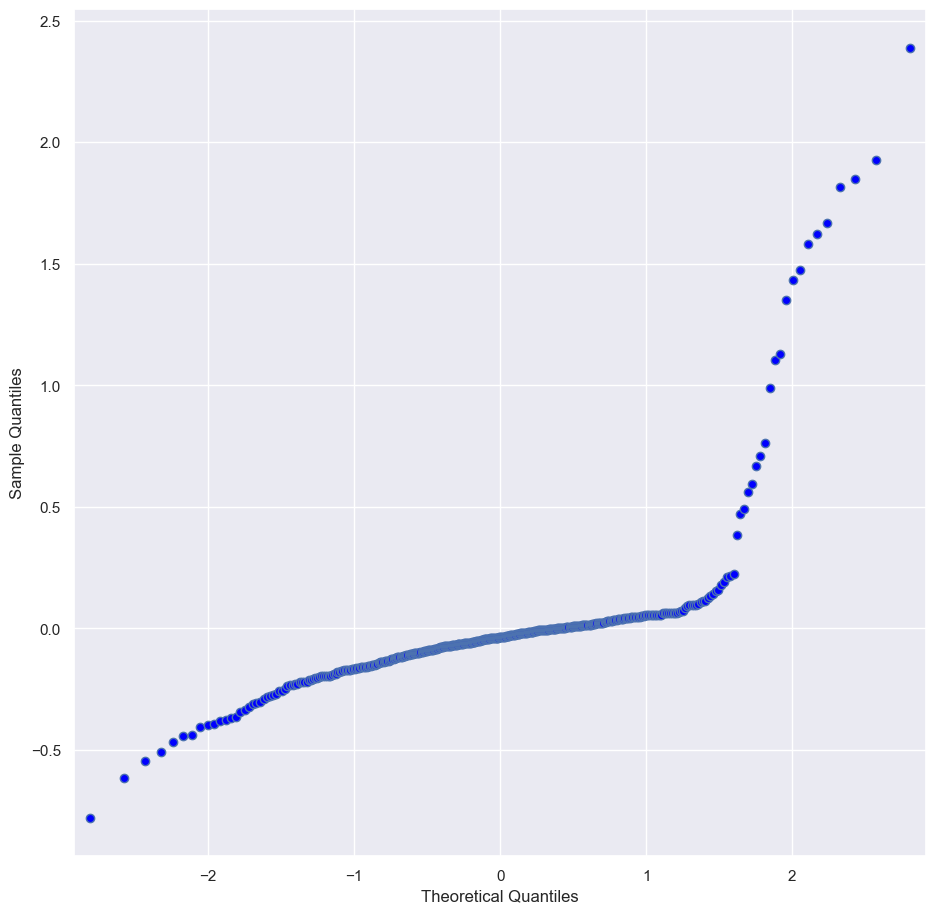

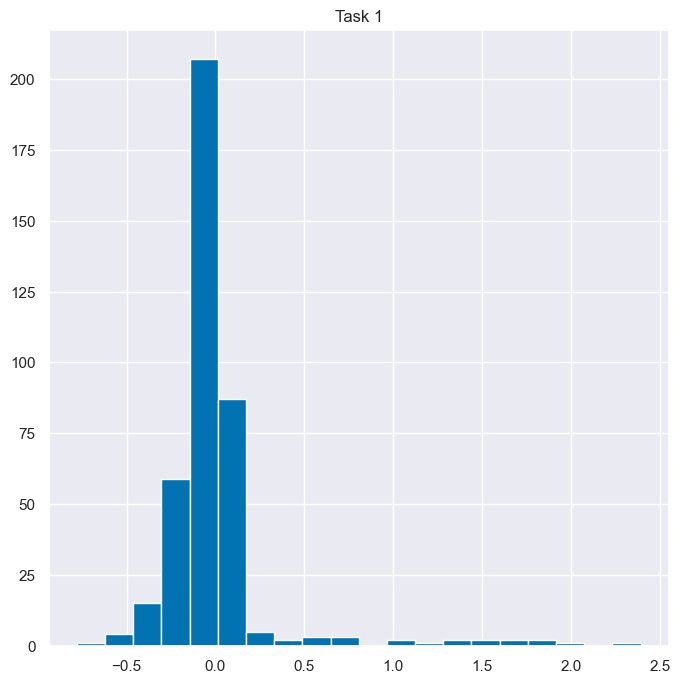

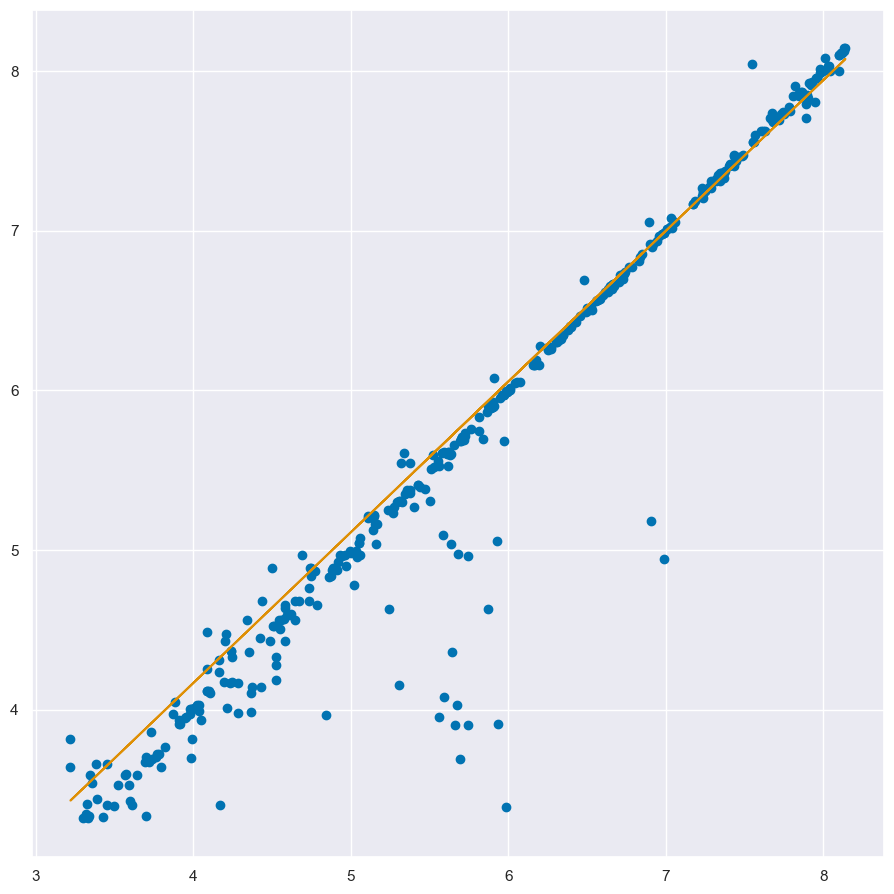

---------
Task 2
---------
Intercept       0.237816
ref_tone_log    0.962233
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     3084.
Date:                Sun, 05 Nov 2023   Prob (F-statistic):          2.01e-188
Time:                        12:04:44   Log-Likelihood:                -277.27
No. Observations:                 396   AIC:                             558.5
Df Residuals:                     394   BIC:                             566.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


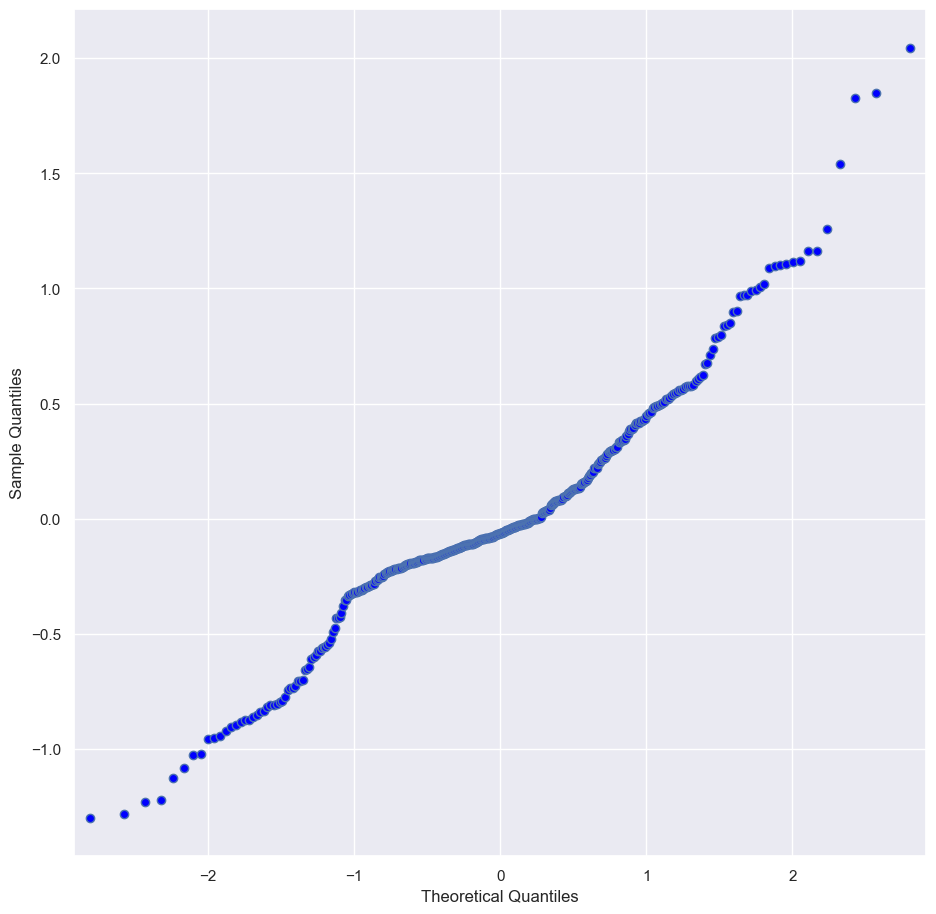

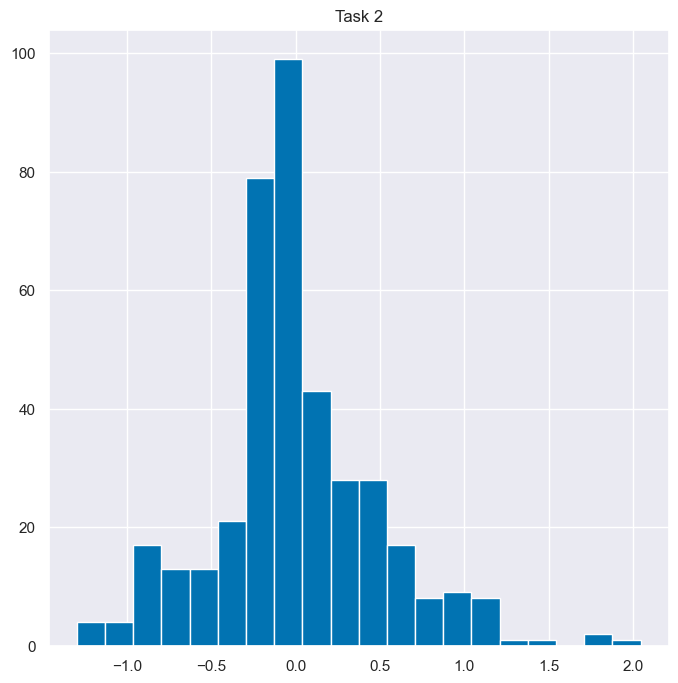

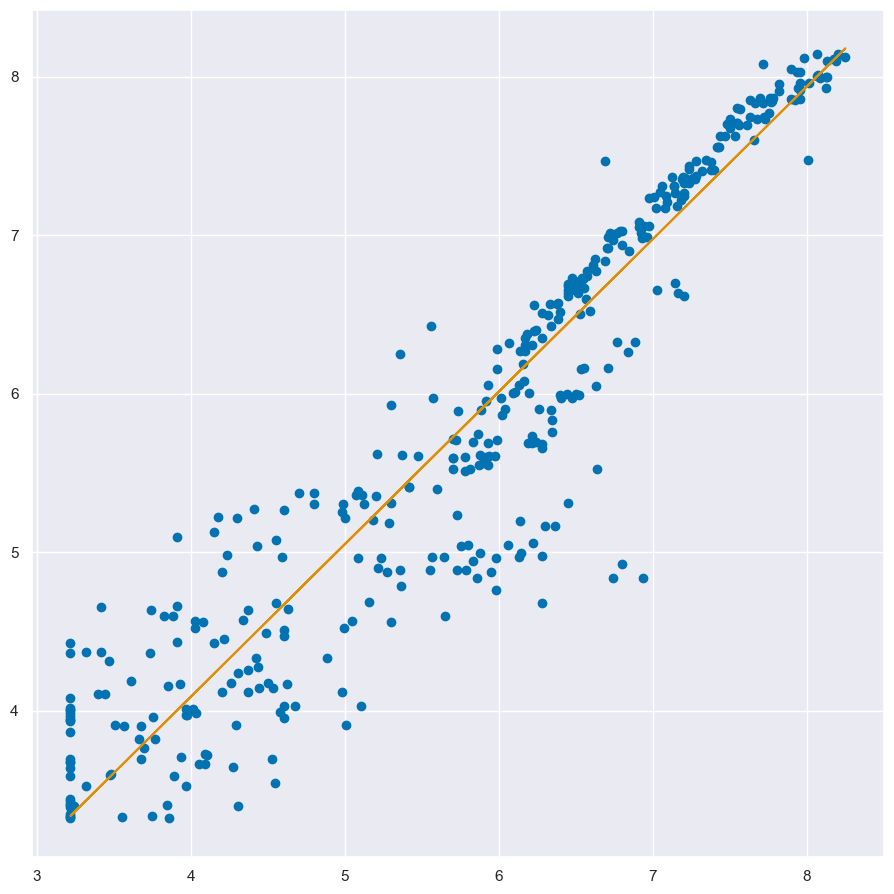

---------
Task 3
---------
Intercept       2.233838
ref_tone_log    0.665198
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1063.
Date:                Sun, 05 Nov 2023   Prob (F-statistic):          2.22e-107
Time:                        12:04:44   Log-Likelihood:                -280.73
No. Observations:                 347   AIC:                             565.5
Df Residuals:                     345   BIC:                             573.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


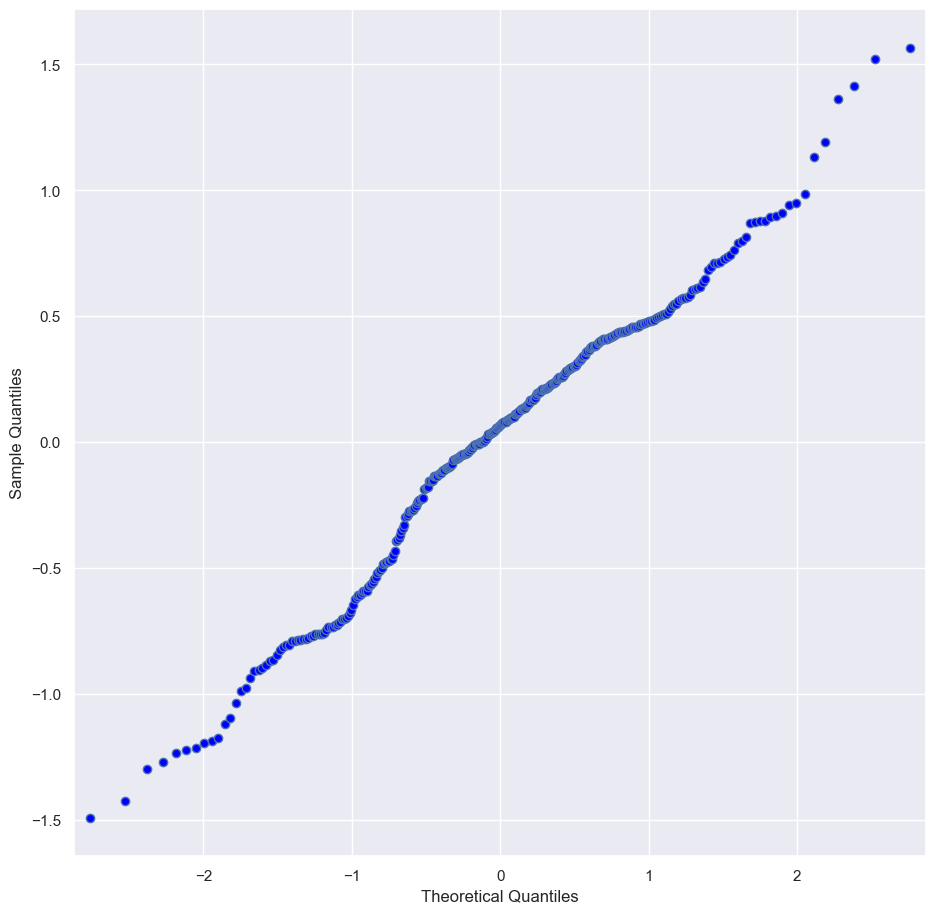

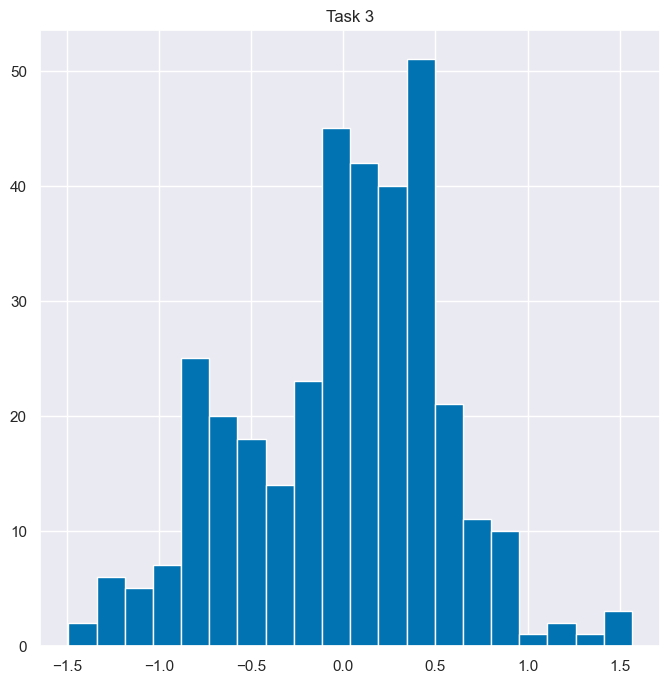

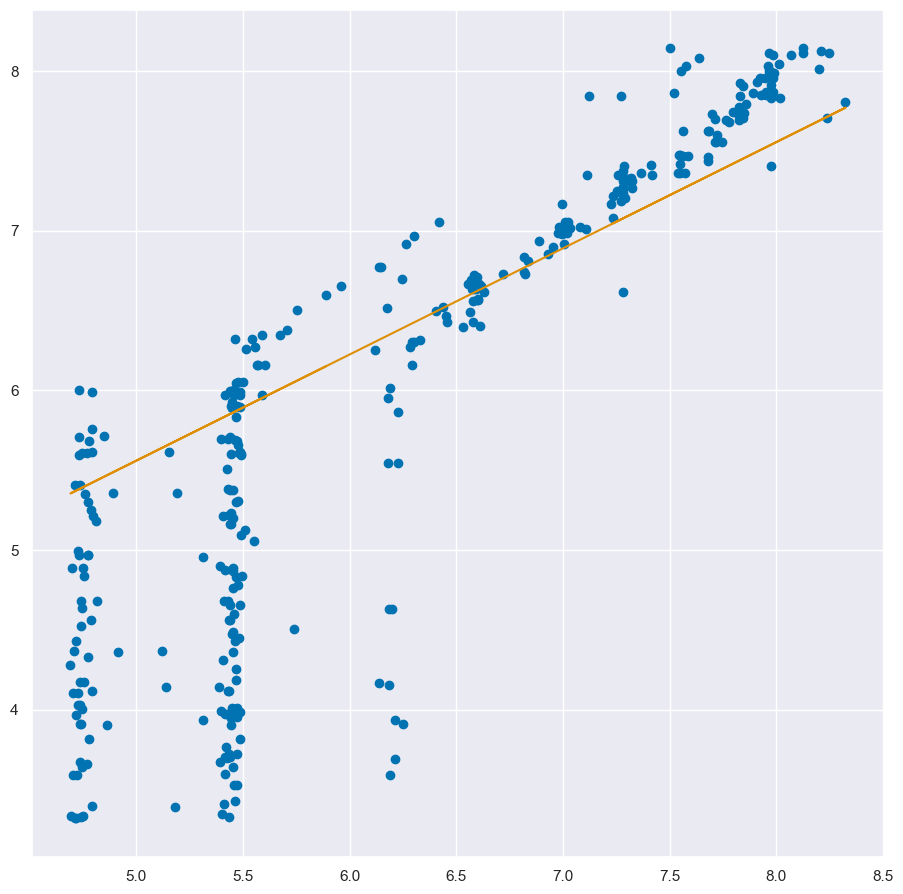

---------
Task 3 upper
---------
Intercept      -0.838990
ref_tone_log    1.108823
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     925.0
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           3.65e-68
Time:                        12:04:45   Log-Likelihood:                -6.5474
No. Observations:                 161   AIC:                             17.09
Df Residuals:                     159   BIC:                             23.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


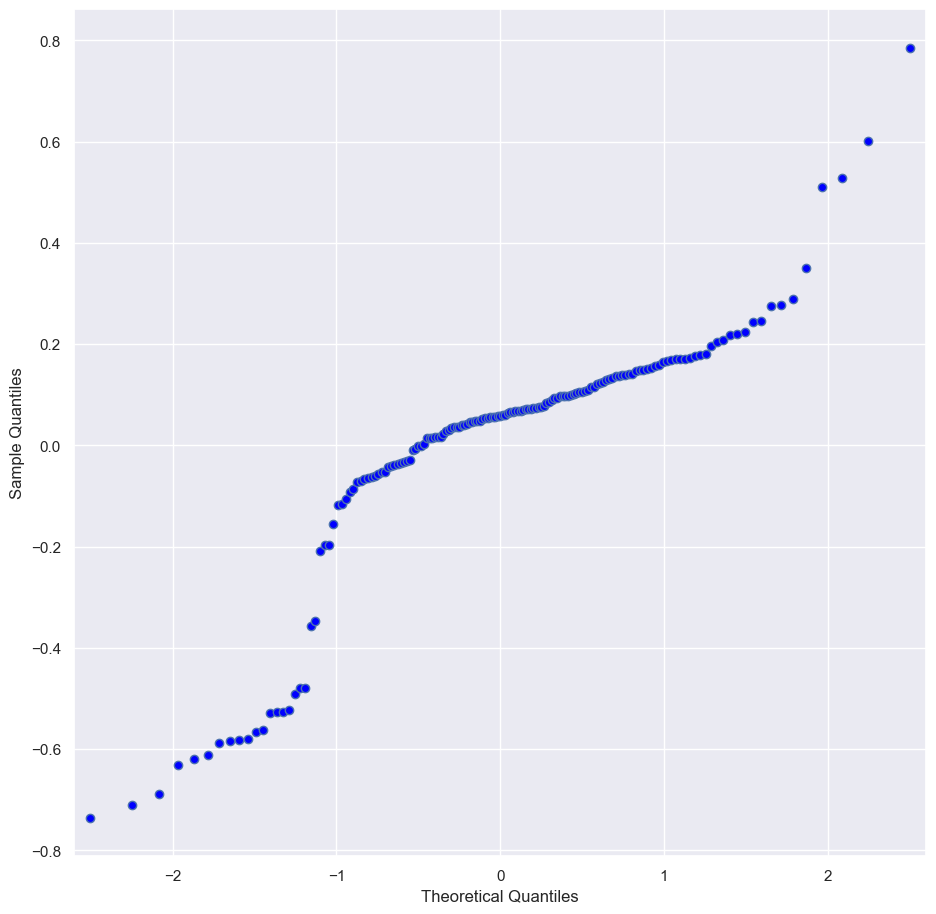

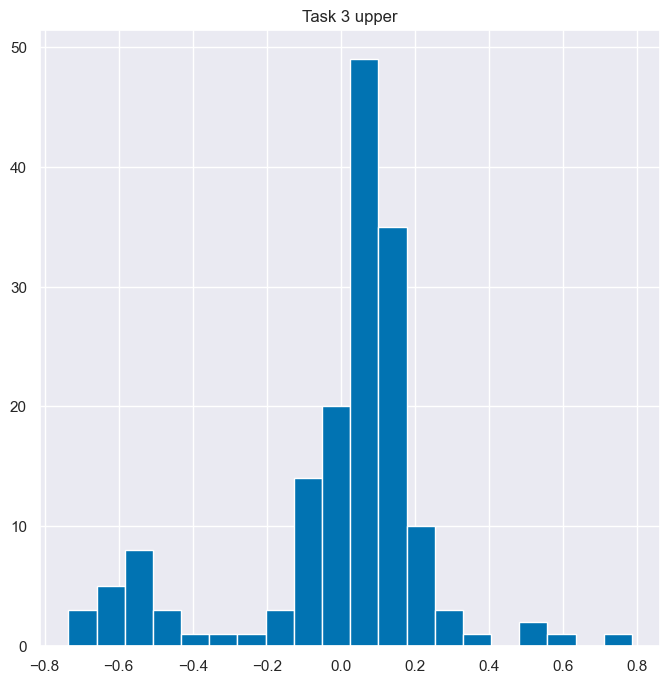

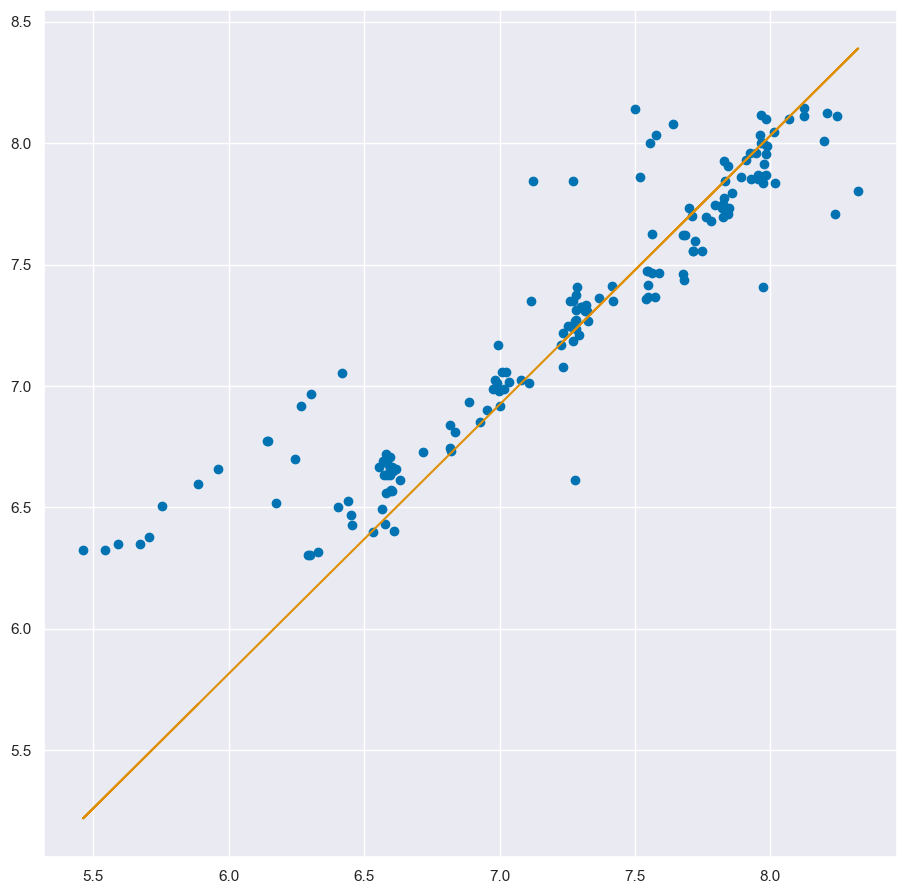

---------
Task 3 Lower
---------
Intercept       4.801597
ref_tone_log    0.102522
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     8.418
Date:                Sun, 05 Nov 2023   Prob (F-statistic):            0.00417
Time:                        12:04:46   Log-Likelihood:                -100.69
No. Observations:                 186   AIC:                             205.4
Df Residuals:                     184   BIC:                             211.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


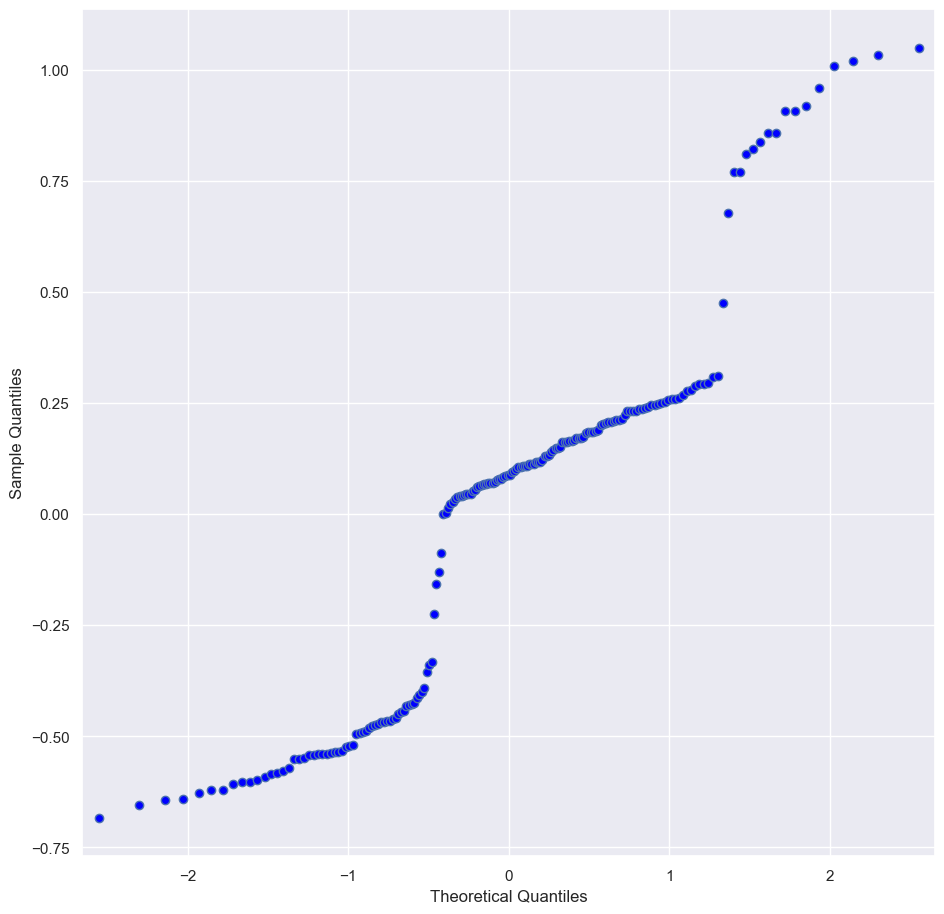

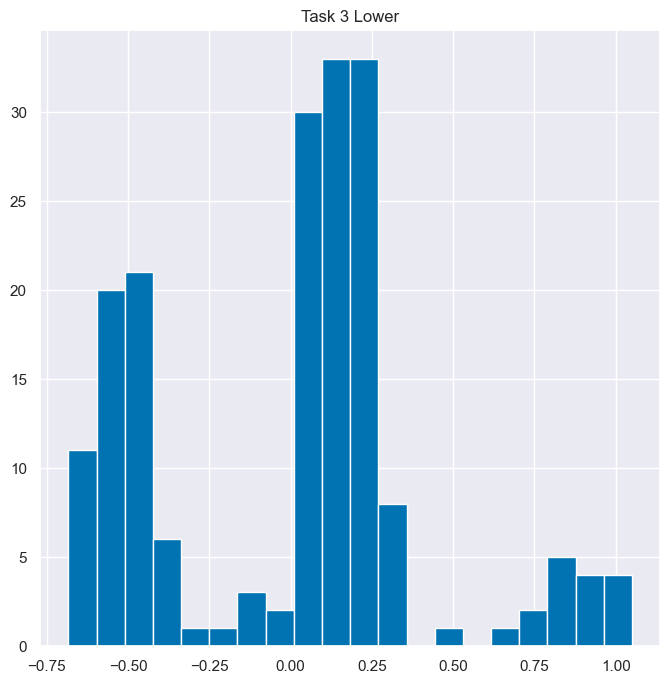

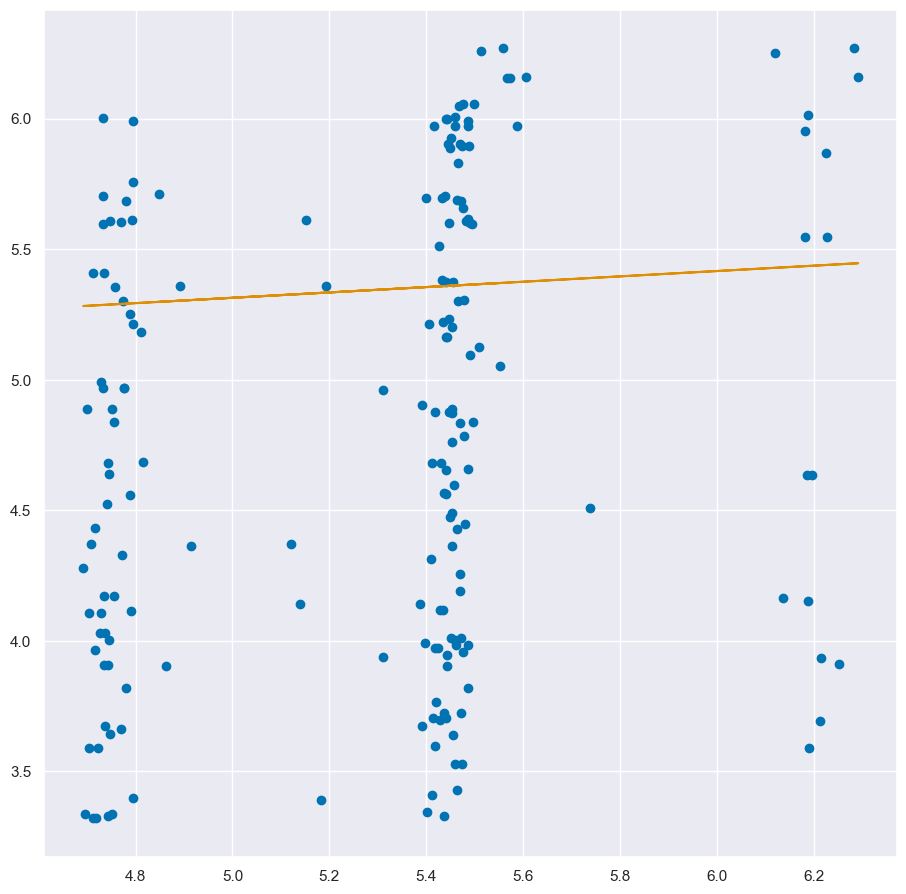

---------
Task 4
---------
Intercept       0.001849
ref_tone_log    0.999737
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.492e+06
Date:                Sun, 05 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:04:46   Log-Likelihood:                 1283.4
No. Observations:                 399   AIC:                            -2563.
Df Residuals:                     397   BIC:                            -2555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


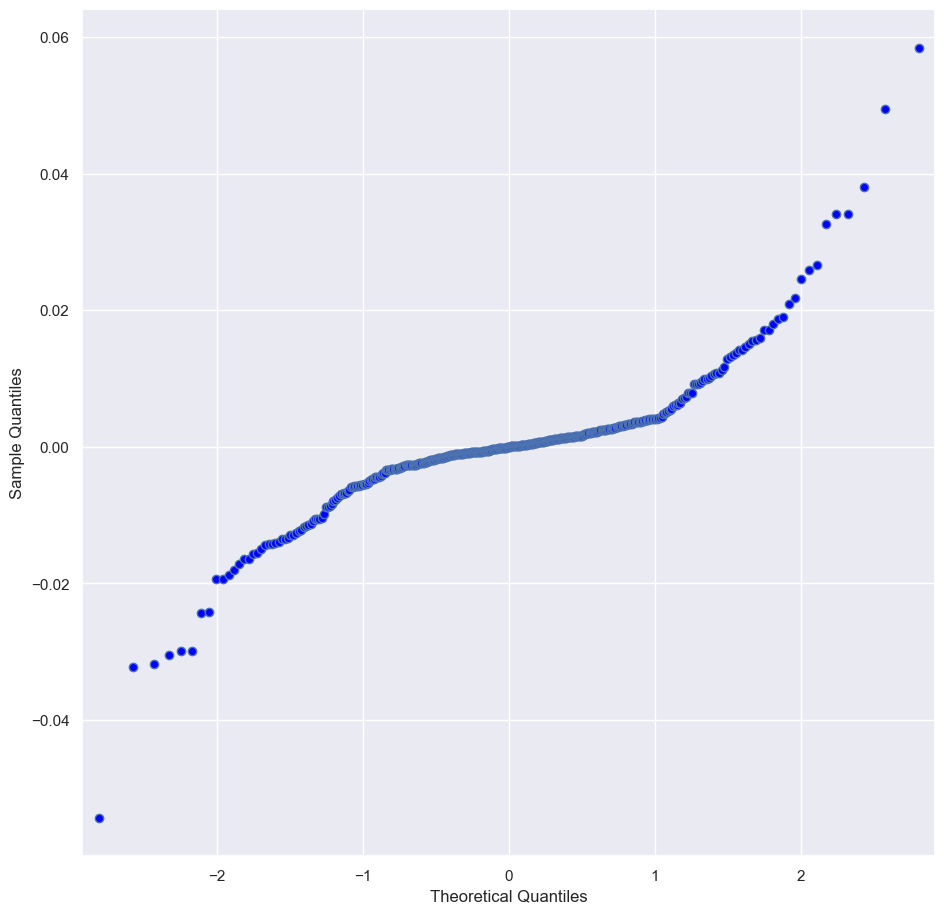

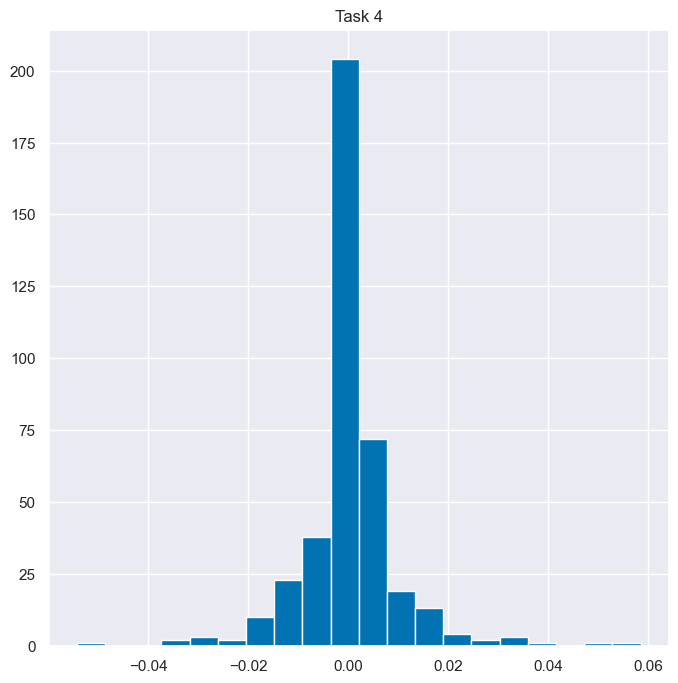

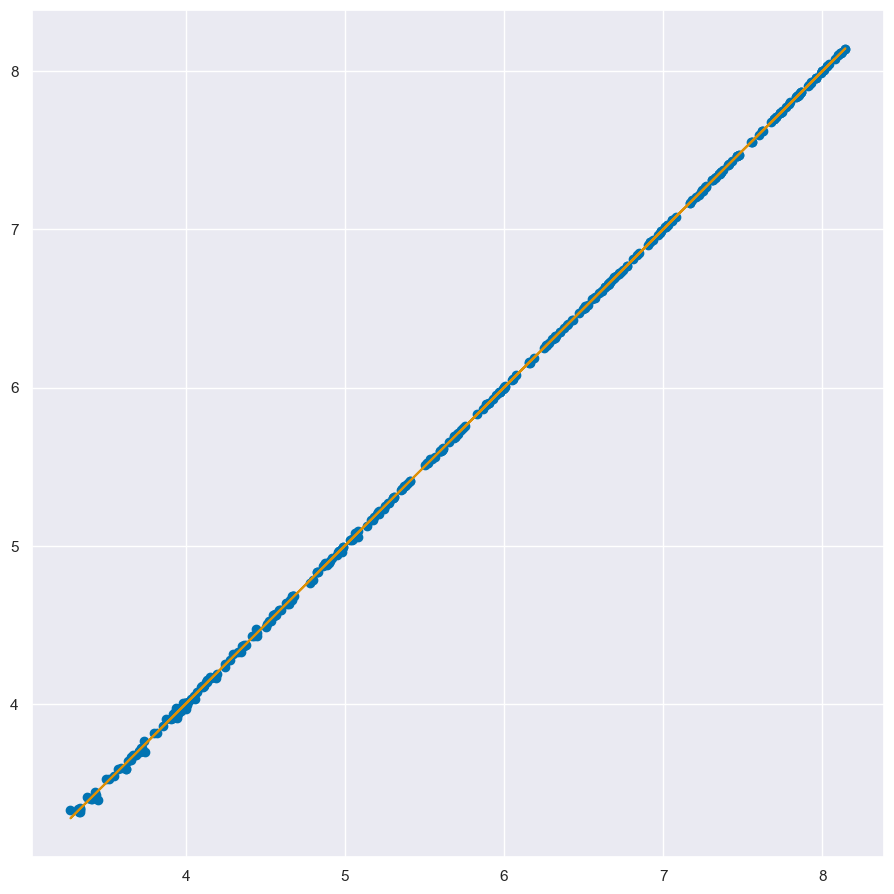

---------
Task 5
---------
Intercept      -0.004260
ref_tone_log    1.000629
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.272e+06
Date:                Sun, 05 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:04:47   Log-Likelihood:                 1252.1
No. Observations:                 399   AIC:                            -2500.
Df Residuals:                     397   BIC:                            -2492.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


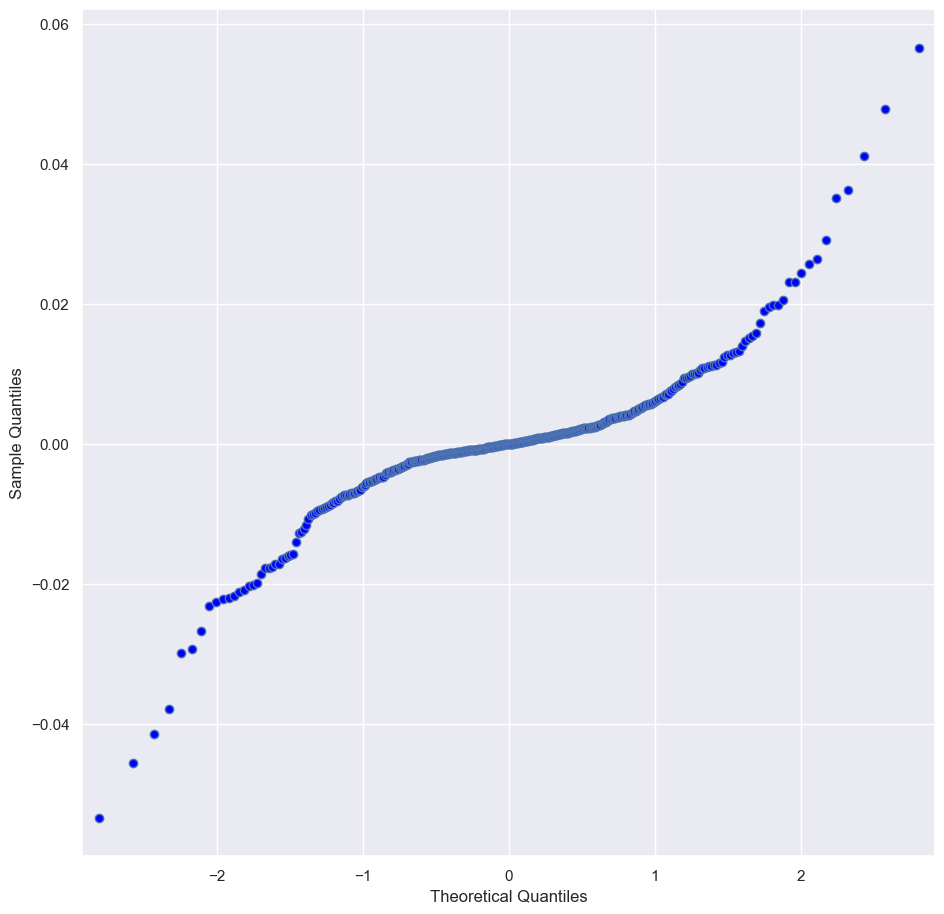

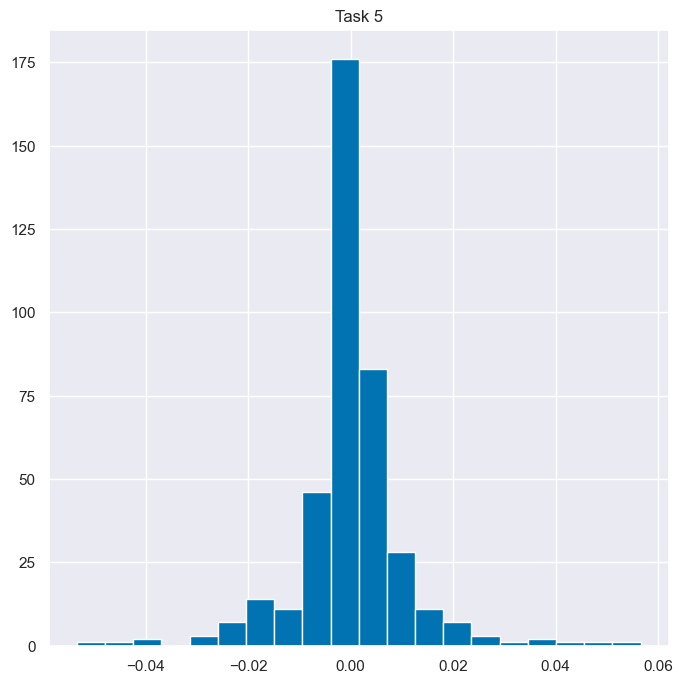

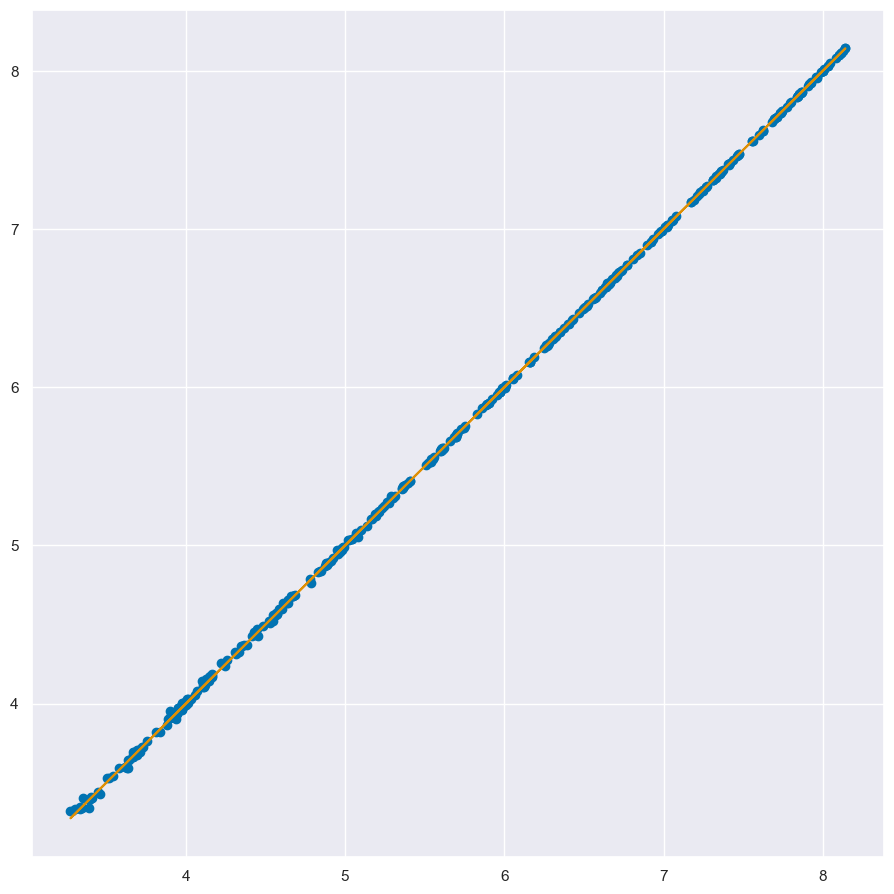

In [23]:
reg_models = []
for i in range(len(models)):
    print('---------')
    print(model_names[i])
    print('---------')
    reg_models.append(reg_model(models[i]))

## How about multiple linear regression? - Model 2

In [24]:
def mrModel(df):
    
    model = sm.ols(formula="adj_tone_log ~ week + ref_tone_log", data=df).fit()
    print(model.params)
    print(model.summary())
    f = statsmodels.api.qqplot(model.resid)
    plt.show()
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(model.resid, 20)
    ax.set_title(model_names[i])
    plt.show()
    
    #create basic scatterplot
    plt.plot(df['adj_tone_log'], df['ref_tone_log'], 'o')

    #obtain m (slope) and b(intercept) of linear regression line
    #m = reg.coef_
    #b = reg.intercept_
    m = 0
    for each in model.params[1:]:
        m = m + each
    b = model.params[0]
    

    #add linear regression line to scatterplot 
    plt.plot(df['adj_tone_log'], m*df['adj_tone_log']+b)
    plt.show()
    return model
    

---------
Task 1
---------
Intercept       0.558281
week           -0.035007
ref_tone_log    0.942653
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     3491.
Date:                Sun, 05 Nov 2023   Prob (F-statistic):          3.15e-252
Time:                        12:04:47   Log-Likelihood:                -111.13
No. Observations:                 399   AIC:                             228.3
Df Residuals:                     396   BIC:                             240.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


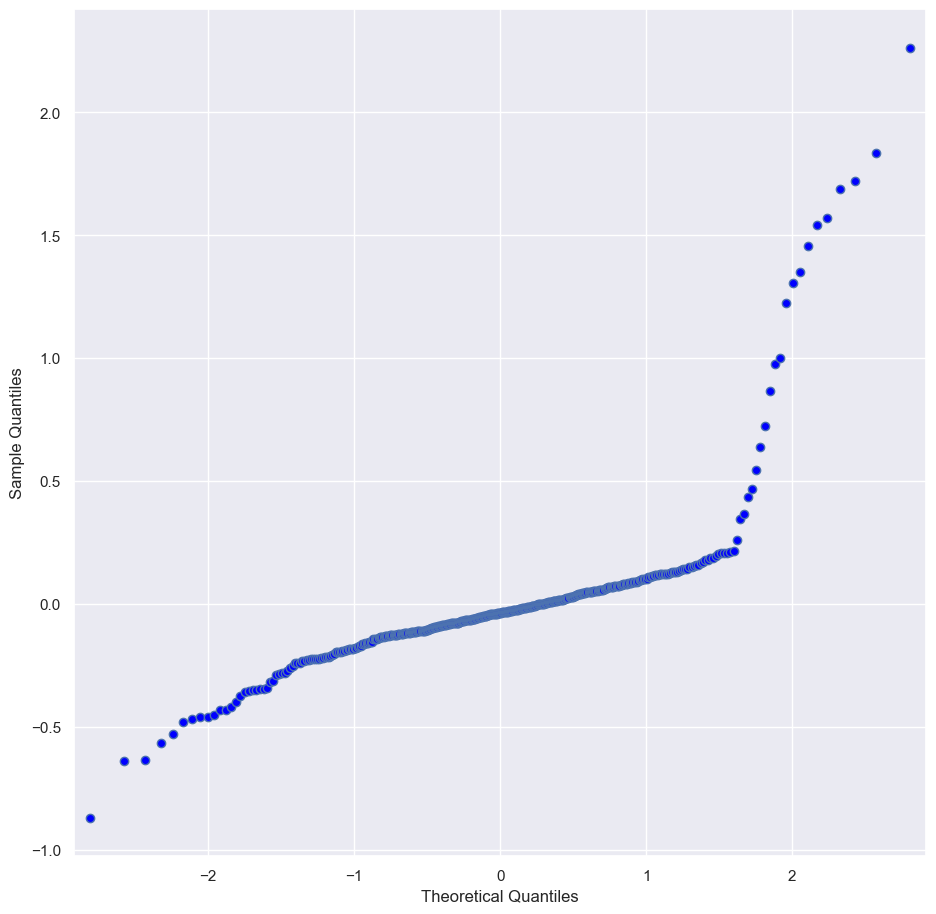

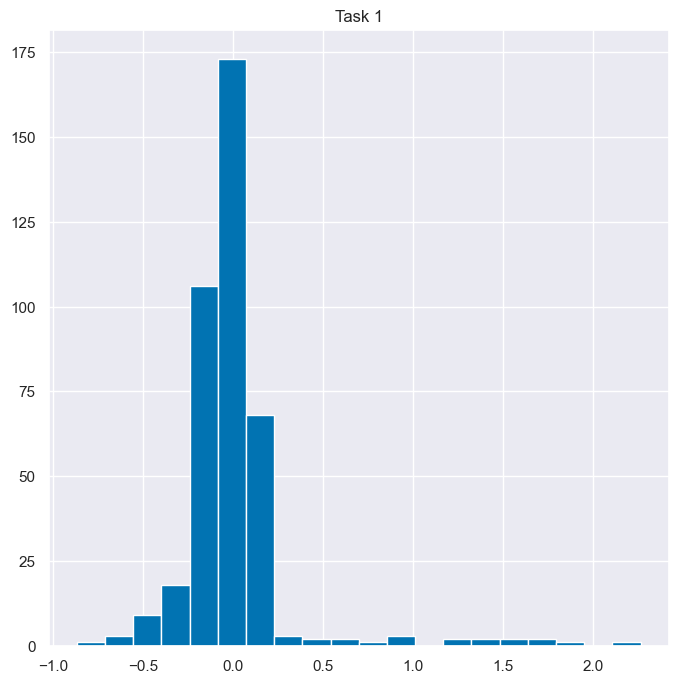

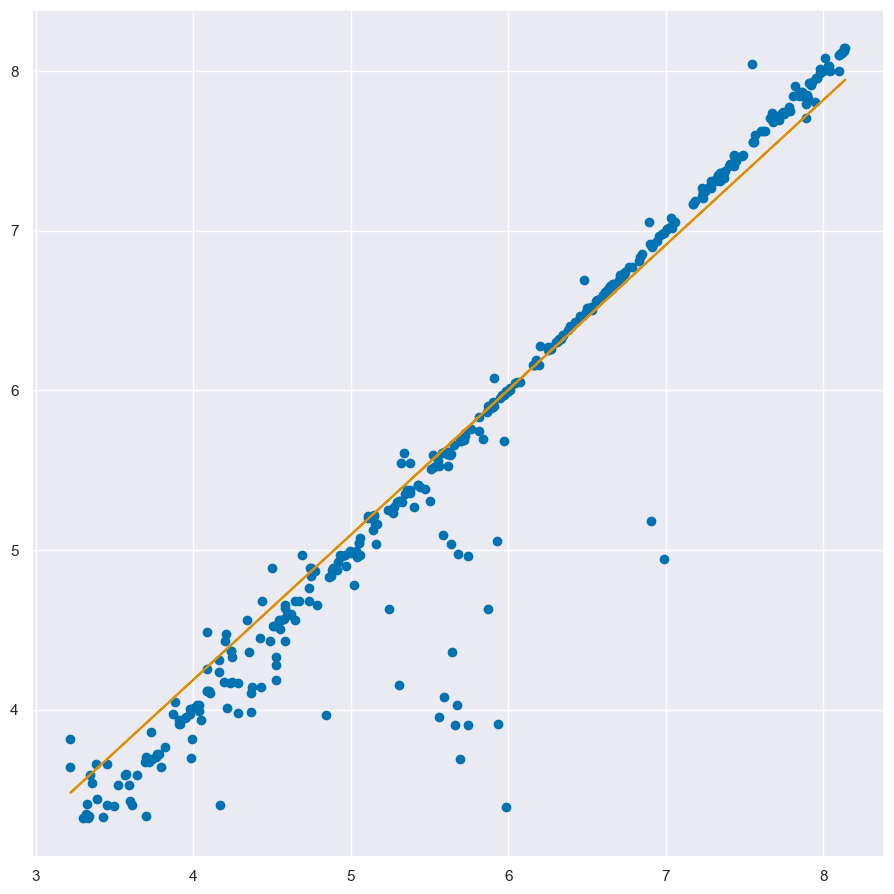

---------
Task 2
---------
Intercept       0.188363
week            0.010567
ref_tone_log    0.962515
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1543.
Date:                Sun, 05 Nov 2023   Prob (F-statistic):          7.61e-187
Time:                        12:04:48   Log-Likelihood:                -276.66
No. Observations:                 396   AIC:                             559.3
Df Residuals:                     393   BIC:                             571.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


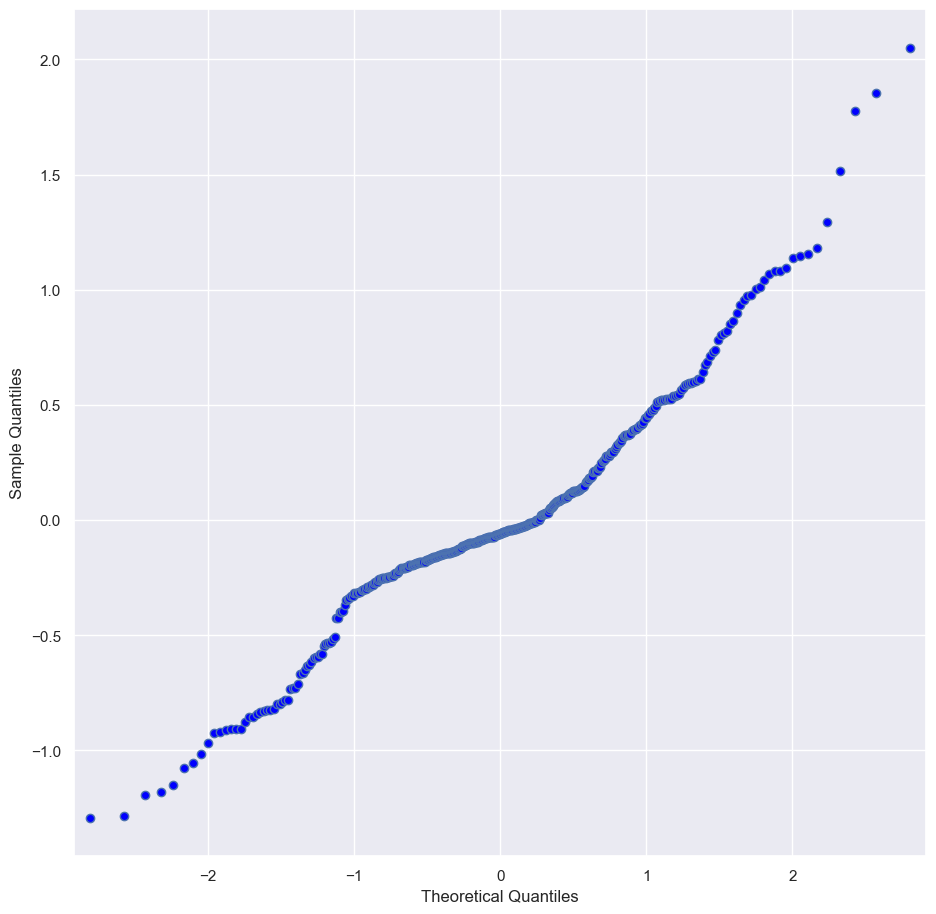

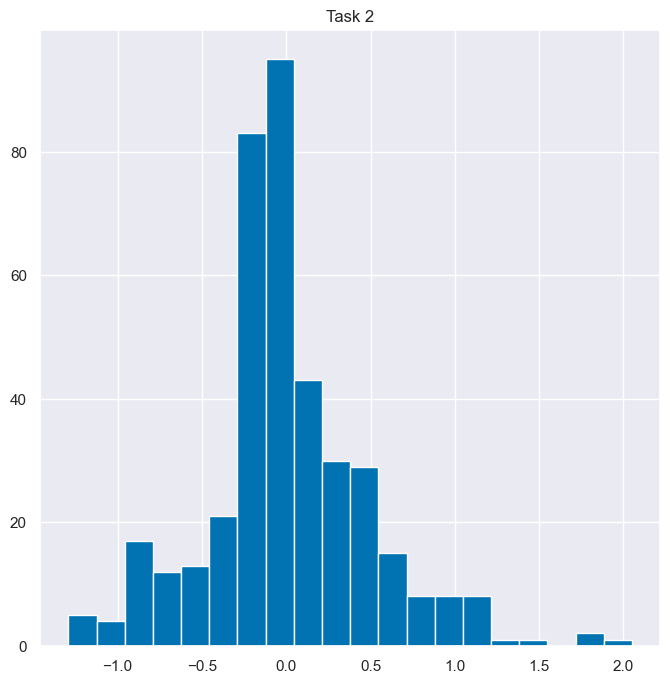

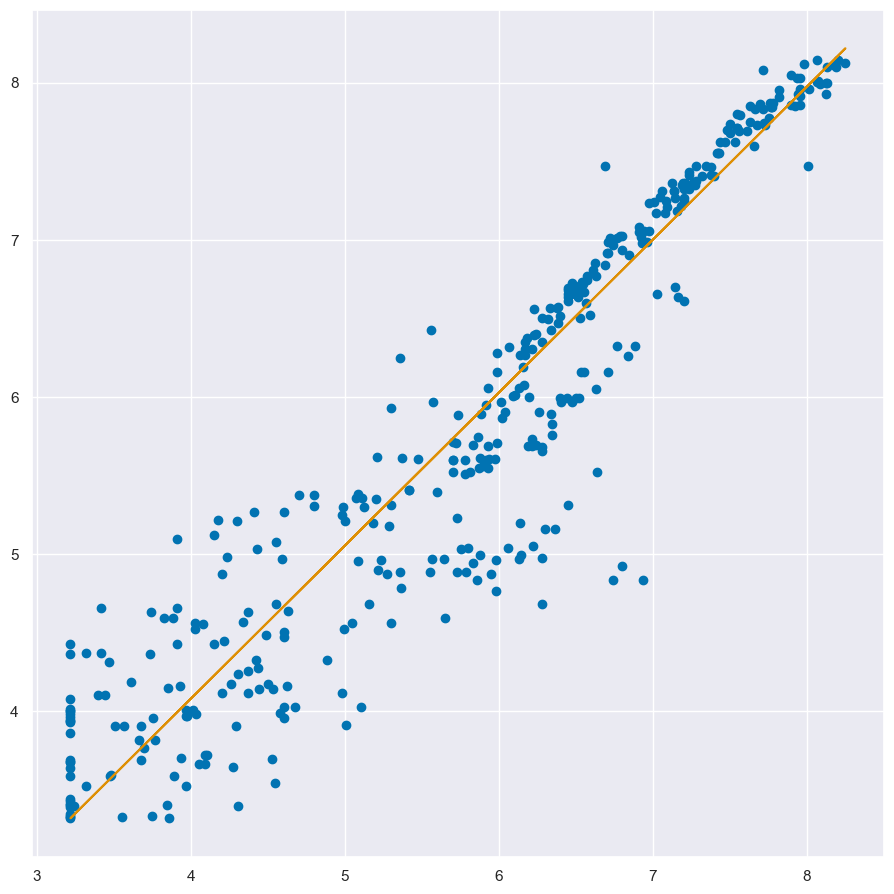

---------
Task 3
---------
Intercept       2.508851
week           -0.052060
ref_tone_log    0.660085
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     572.4
Date:                Sun, 05 Nov 2023   Prob (F-statistic):          3.66e-110
Time:                        12:04:48   Log-Likelihood:                -270.53
No. Observations:                 347   AIC:                             547.1
Df Residuals:                     344   BIC:                             558.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


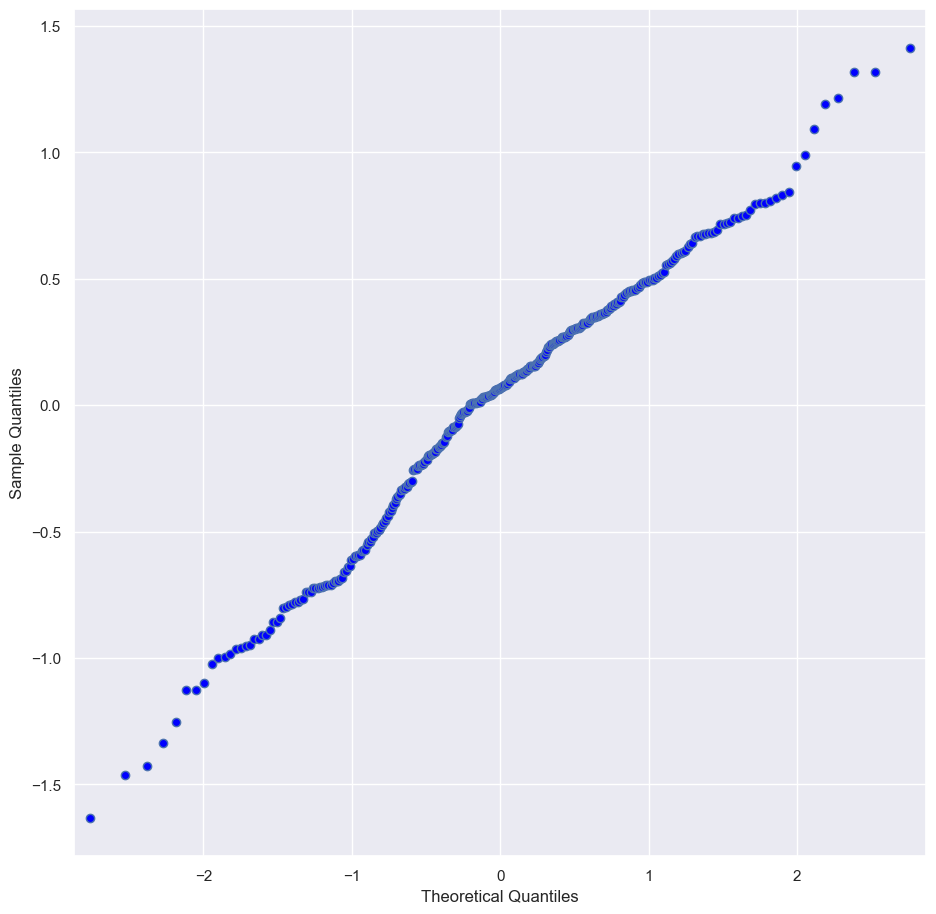

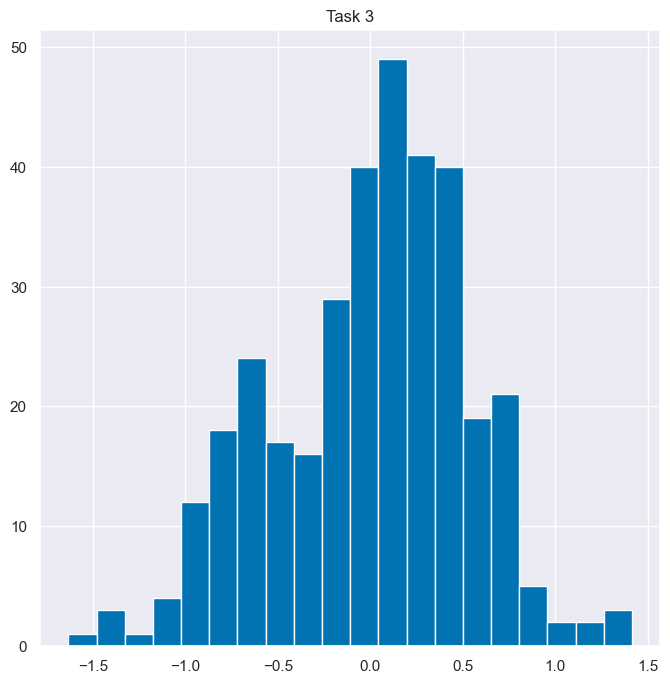

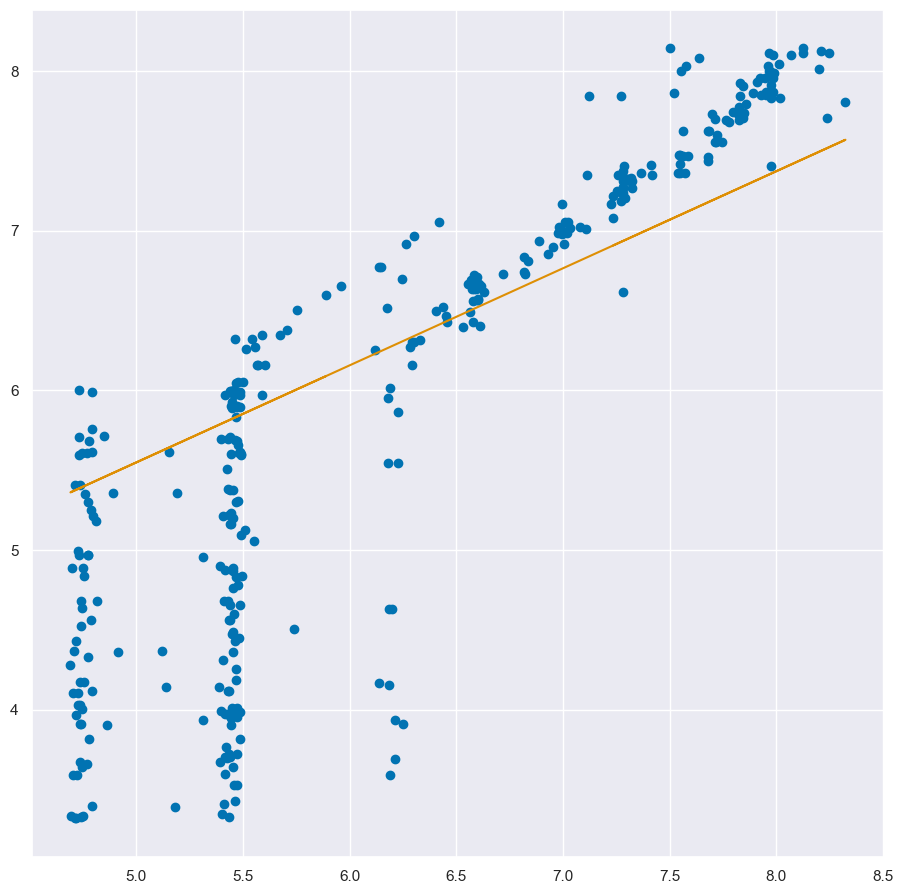

---------
Task 3 upper
---------
Intercept      -0.756466
week           -0.015069
ref_tone_log    1.106775
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     472.6
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           2.10e-67
Time:                        12:04:49   Log-Likelihood:                -4.6163
No. Observations:                 161   AIC:                             15.23
Df Residuals:                     158   BIC:                             24.48
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


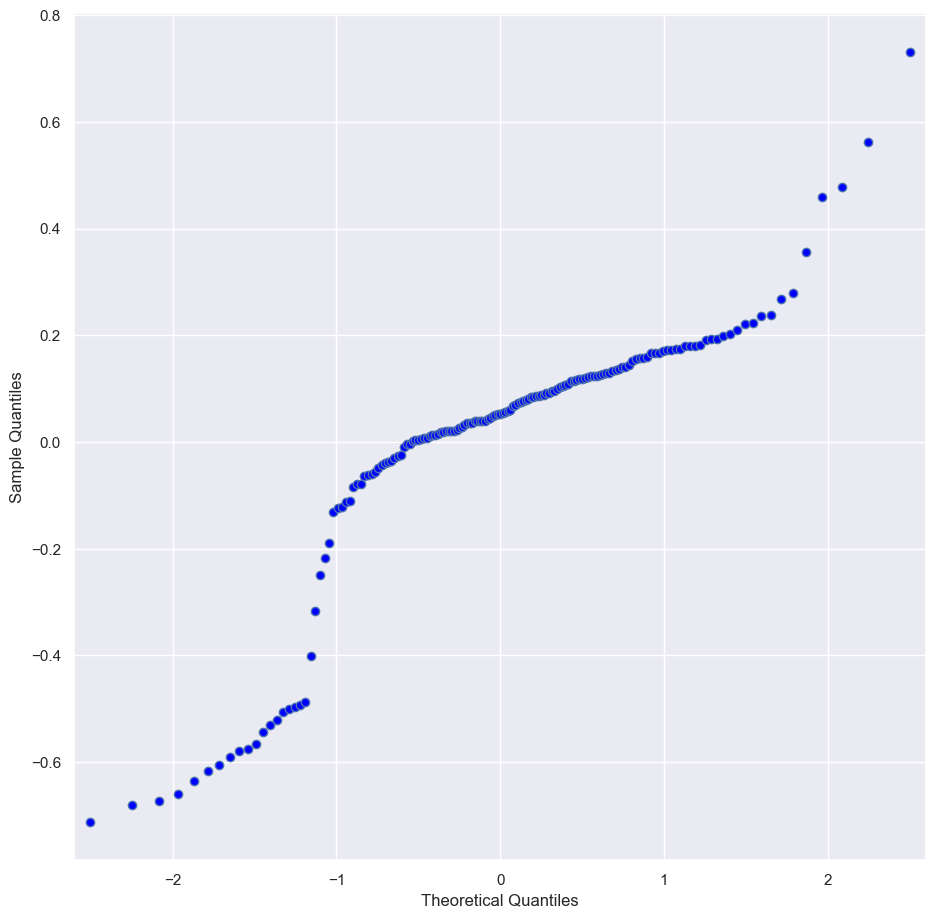

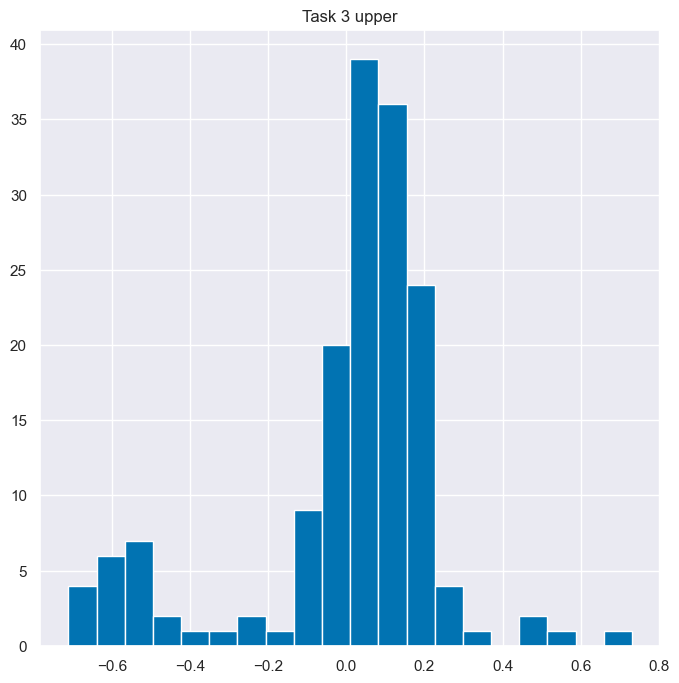

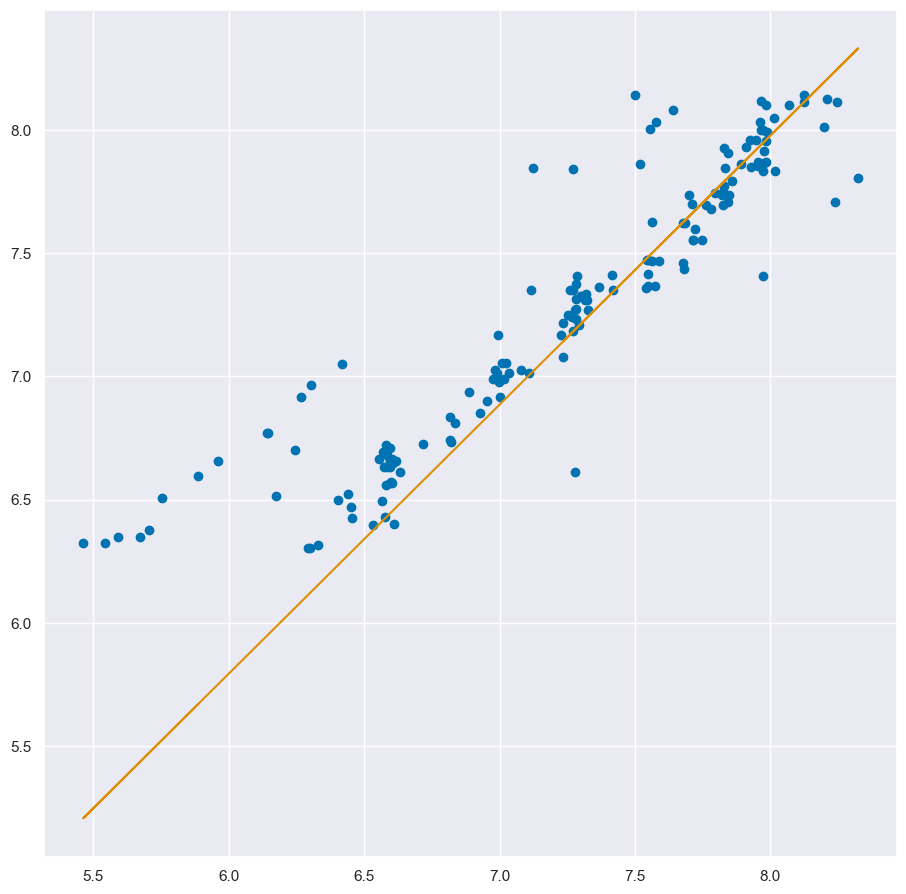

---------
Task 3 Lower
---------
Intercept       5.086169
week           -0.067657
ref_tone_log    0.112074
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     21.62
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           3.72e-09
Time:                        12:04:50   Log-Likelihood:                -85.121
No. Observations:                 186   AIC:                             176.2
Df Residuals:                     183   BIC:                             185.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


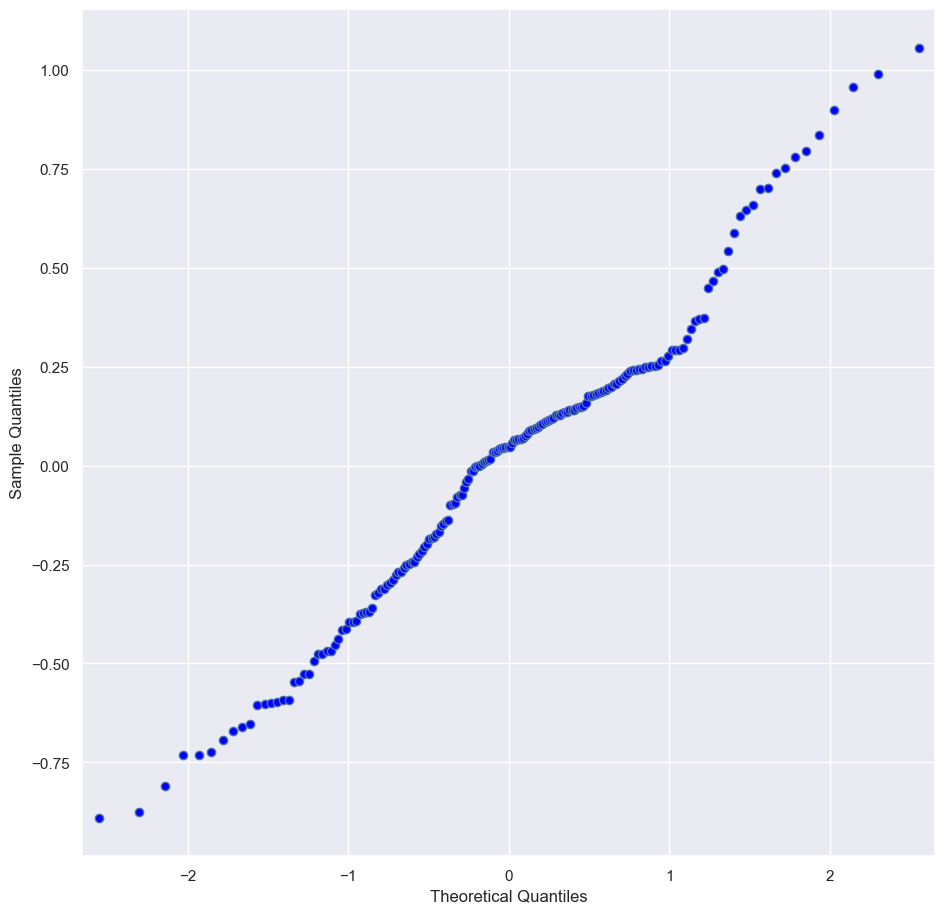

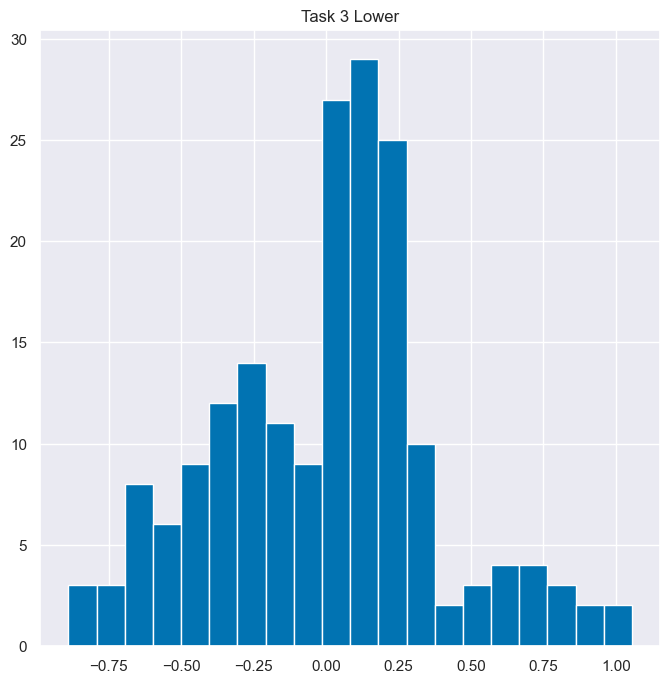

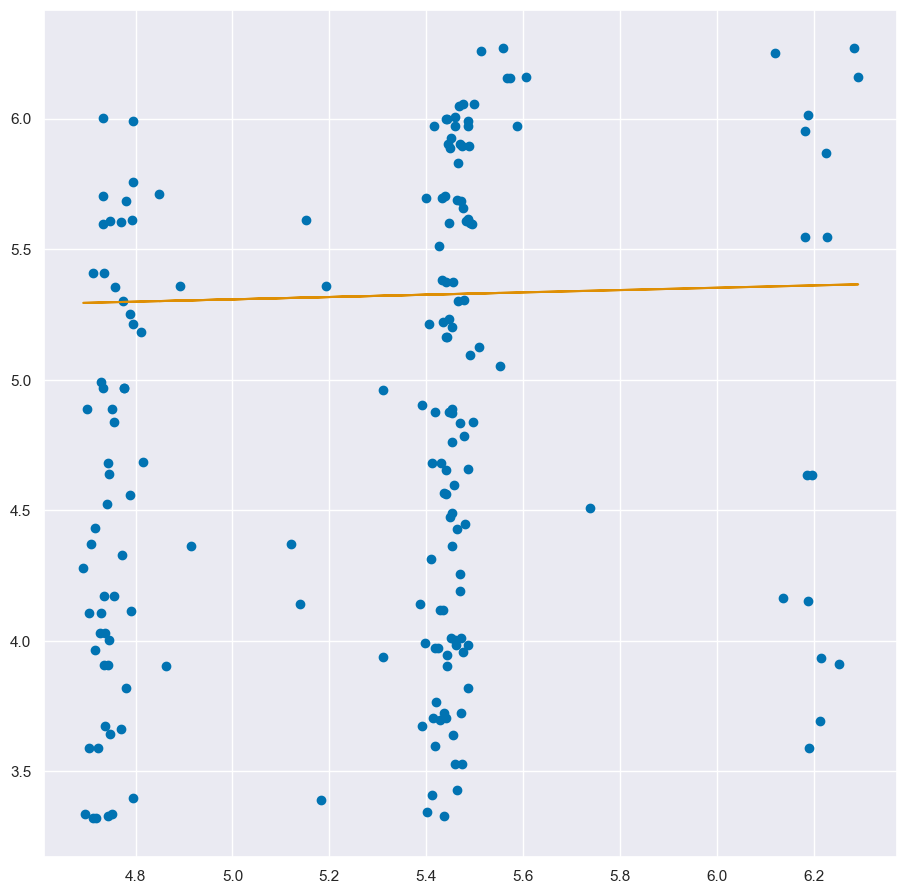

---------
Task 4
---------
Intercept       0.002853
week           -0.000214
ref_tone_log    0.999731
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.249e+06
Date:                Sun, 05 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:04:50   Log-Likelihood:                 1284.1
No. Observations:                 399   AIC:                            -2562.
Df Residuals:                     396   BIC:                            -2550.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


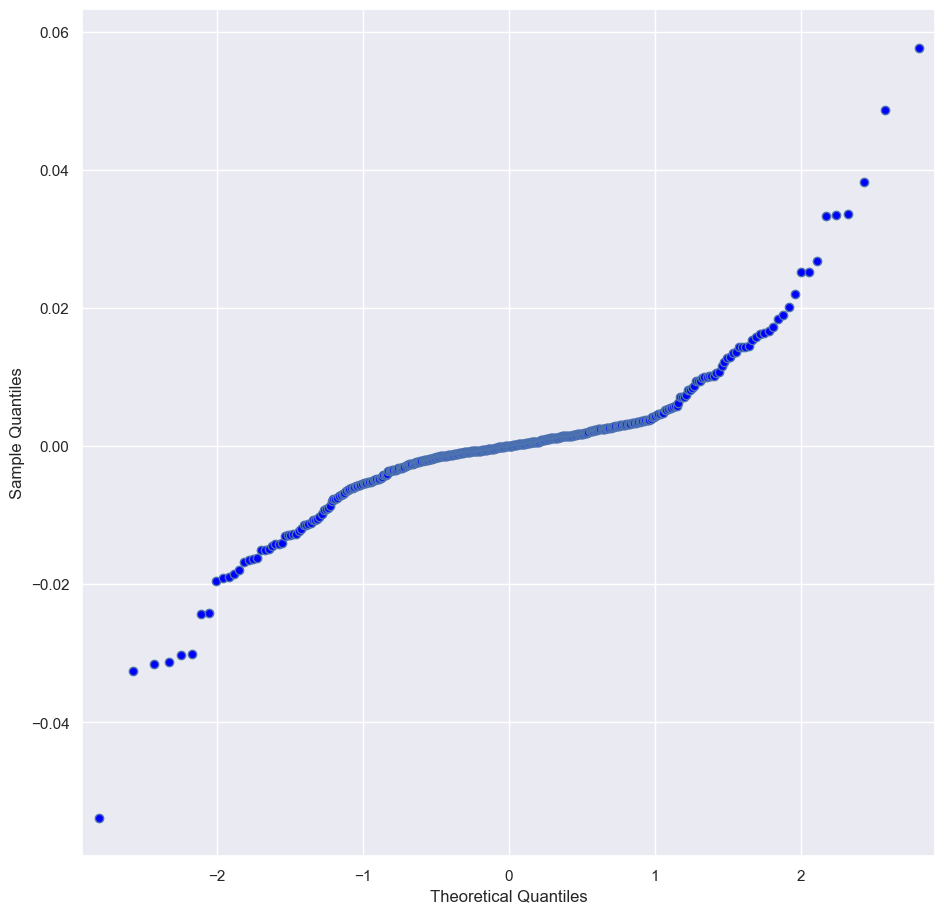

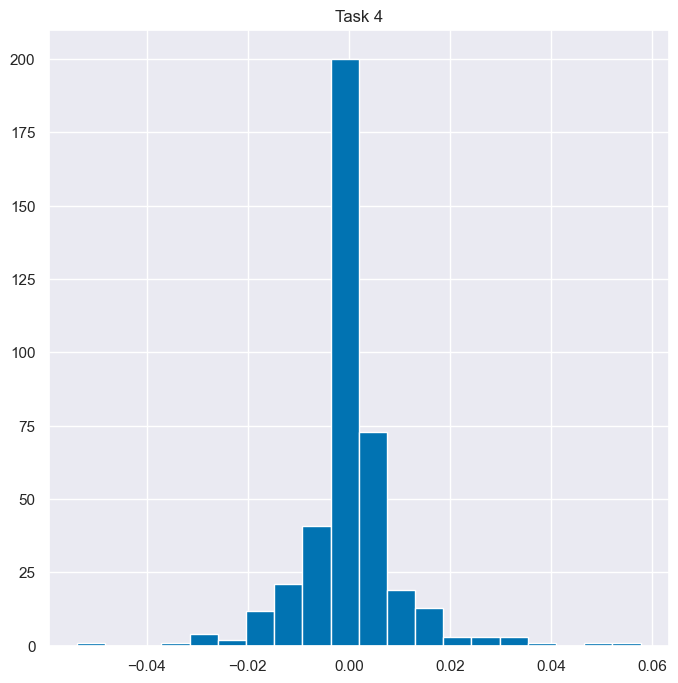

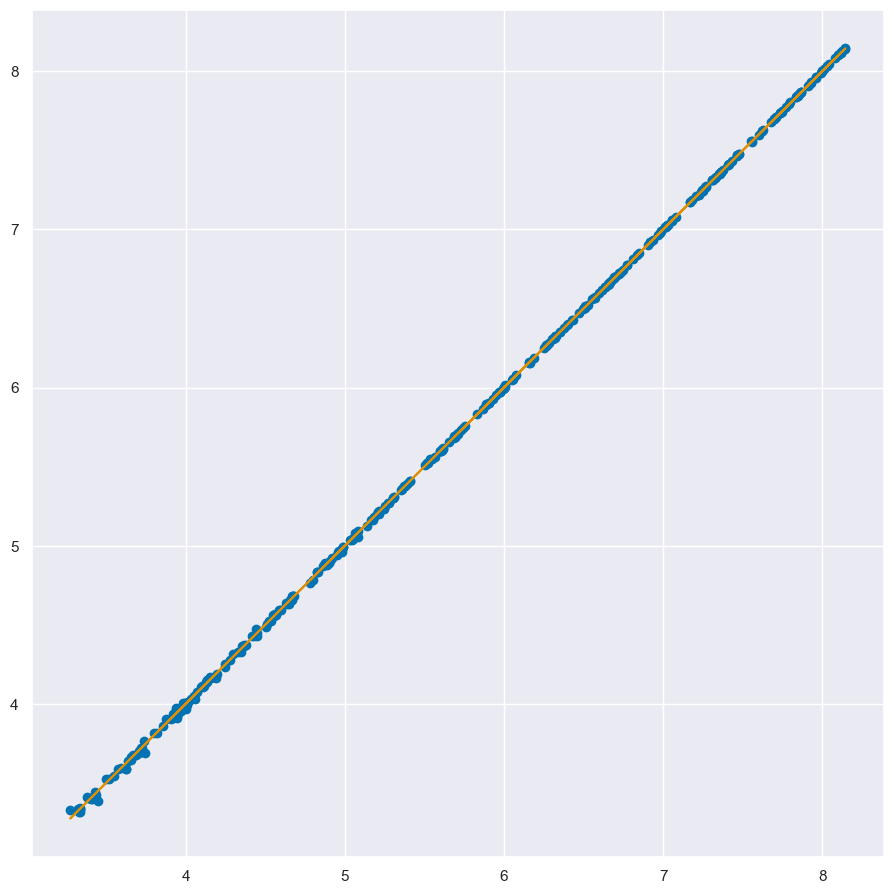

---------
Task 5
---------
Intercept      -0.003960
week           -0.000064
ref_tone_log    1.000627
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.628e+06
Date:                Sun, 05 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:04:51   Log-Likelihood:                 1252.2
No. Observations:                 399   AIC:                            -2498.
Df Residuals:                     396   BIC:                            -2486.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


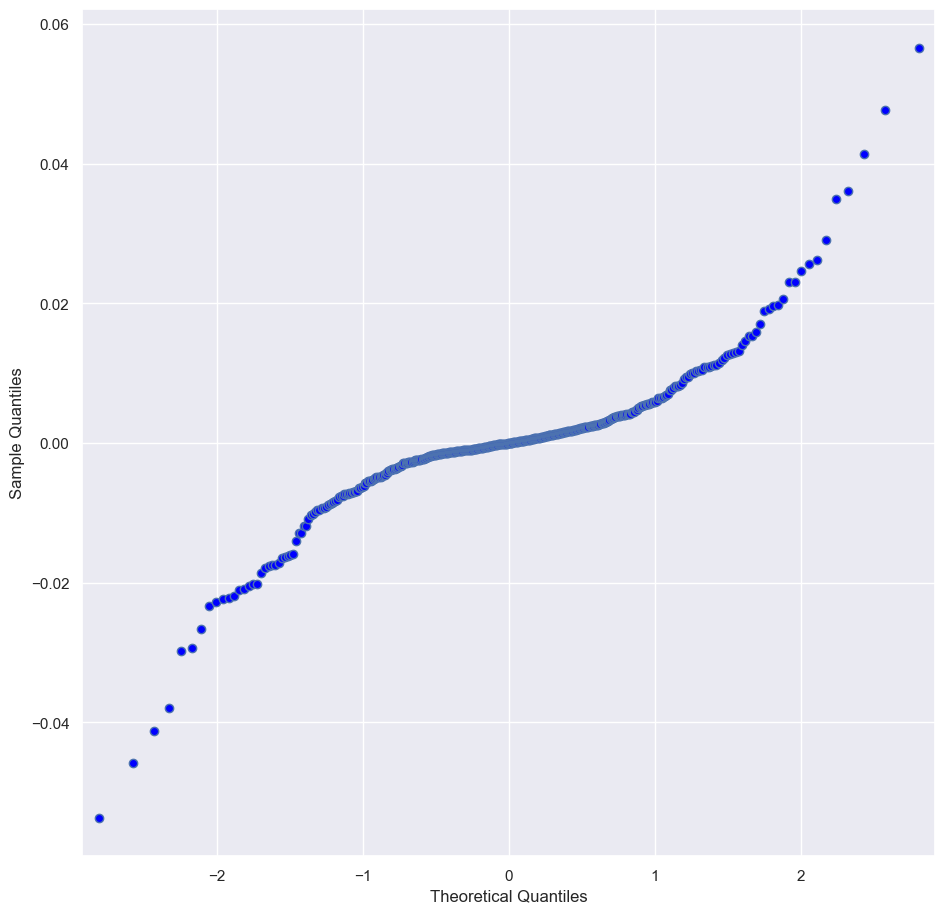

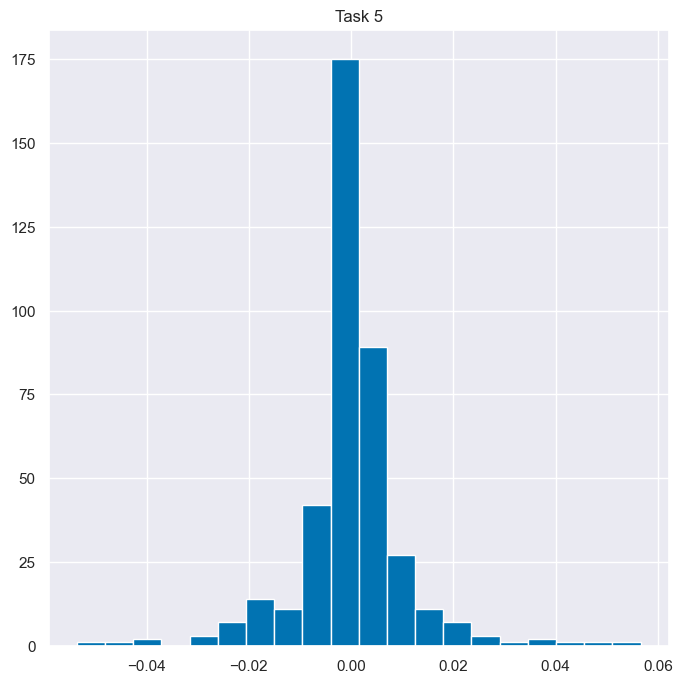

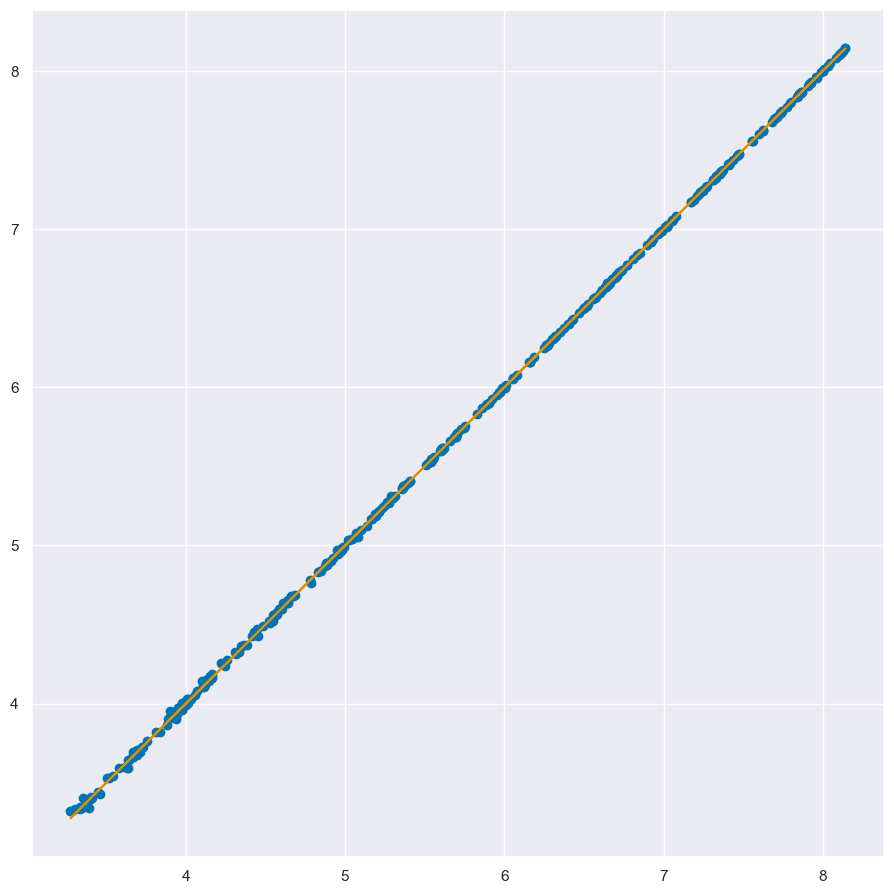

In [25]:
mr_models = []
for i in range(len(models)):
    print('---------')
    print(model_names[i])
    print('---------')
    mr_models.append(mrModel(models[i]))

## Analysis of Accuracy Residuals

In [26]:
quartiles = []
quartile_values = [0,25,50,75,100]
for each in quartile_values:
    quartiles.append(np.percentile(df['ref_tone_log'],each))
    
for i in quartiles:
    print(i)

3.320300449506131
4.571575048793315
5.830617067944859
7.05307875823786
8.142864713944011


In [27]:
task_dfs =[]
for i in df['taskID'].unique():
    task_dfs.append(df[df['taskID'] == i])

quartile_dfs = []
for i in range(len(task_dfs)):
    split_df = []
    for j in range(len(quartiles[:-1])):
        split_df.append(task_dfs[i][(task_dfs[i]['ref_tone_log'] >= quartiles[j]) & (task_dfs[i]['ref_tone_log'] < quartiles[j+1]) ])
    quartile_dfs.append(split_df)
    

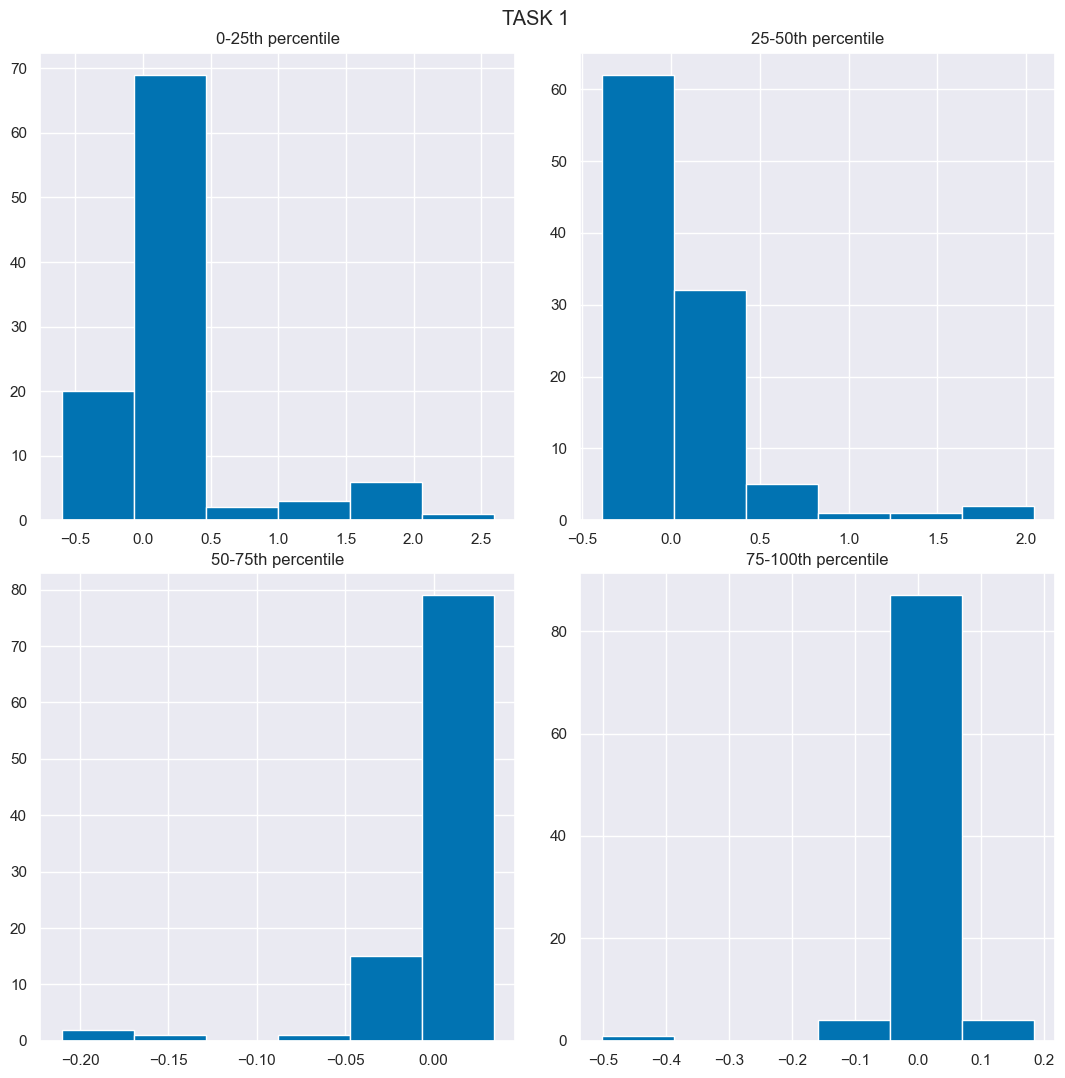

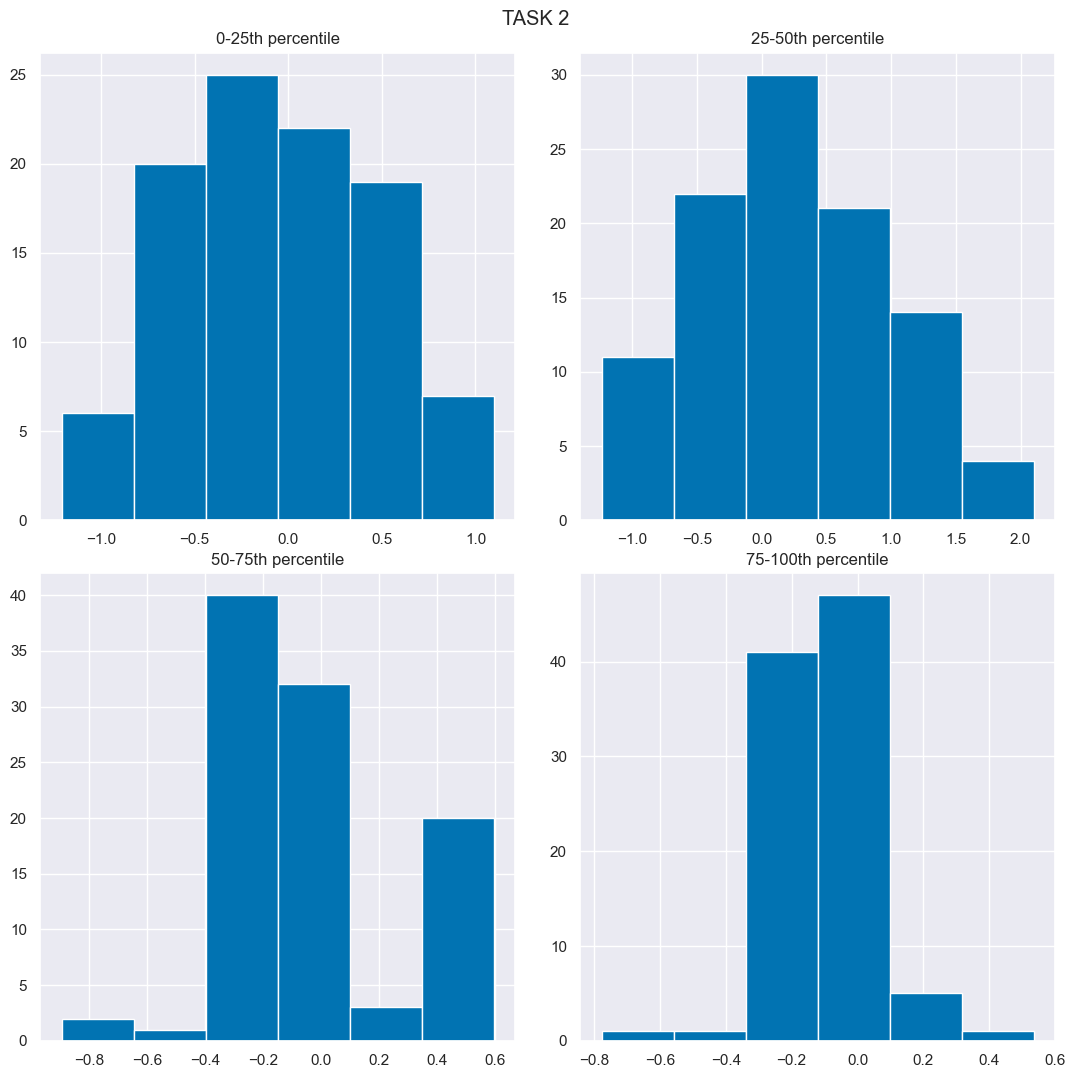

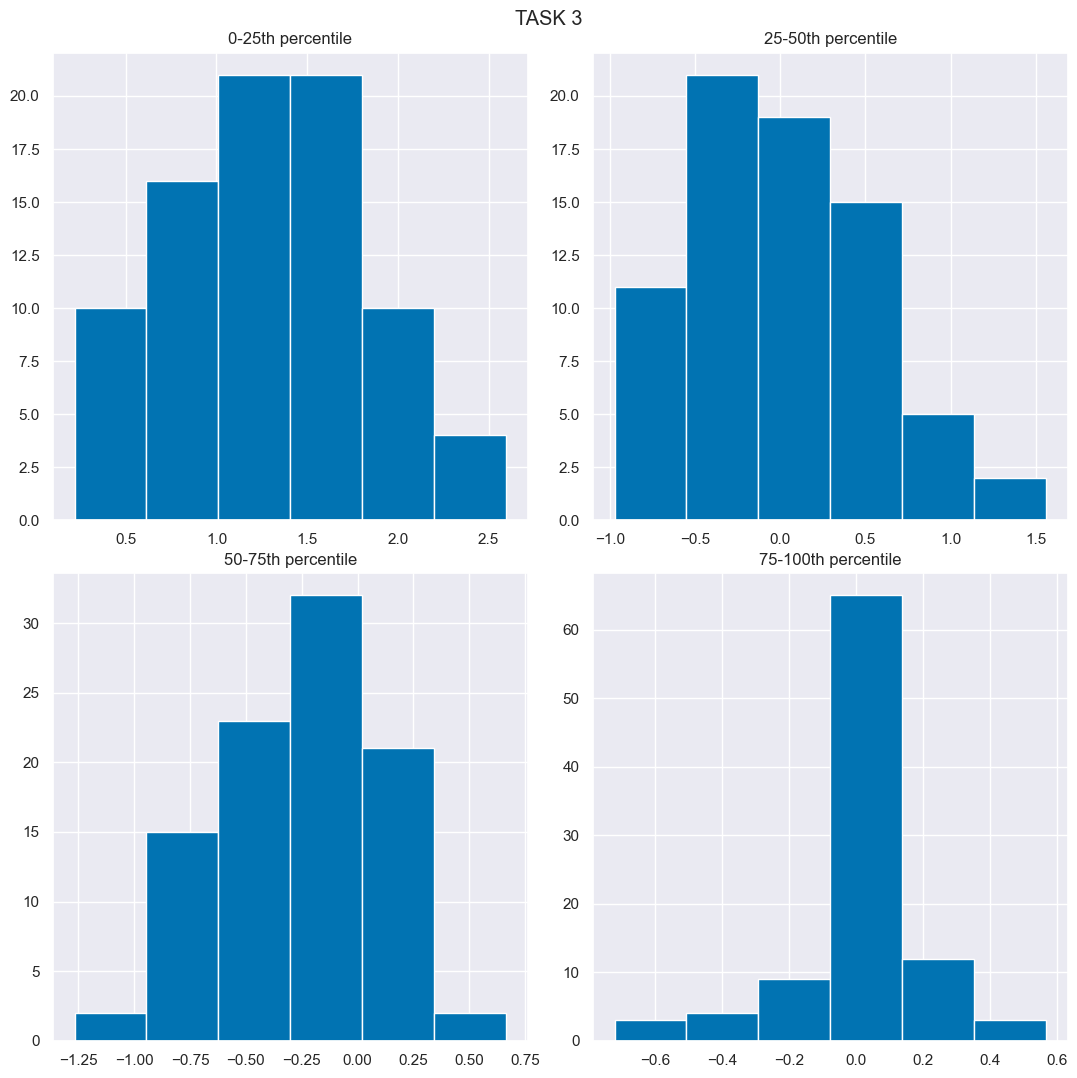

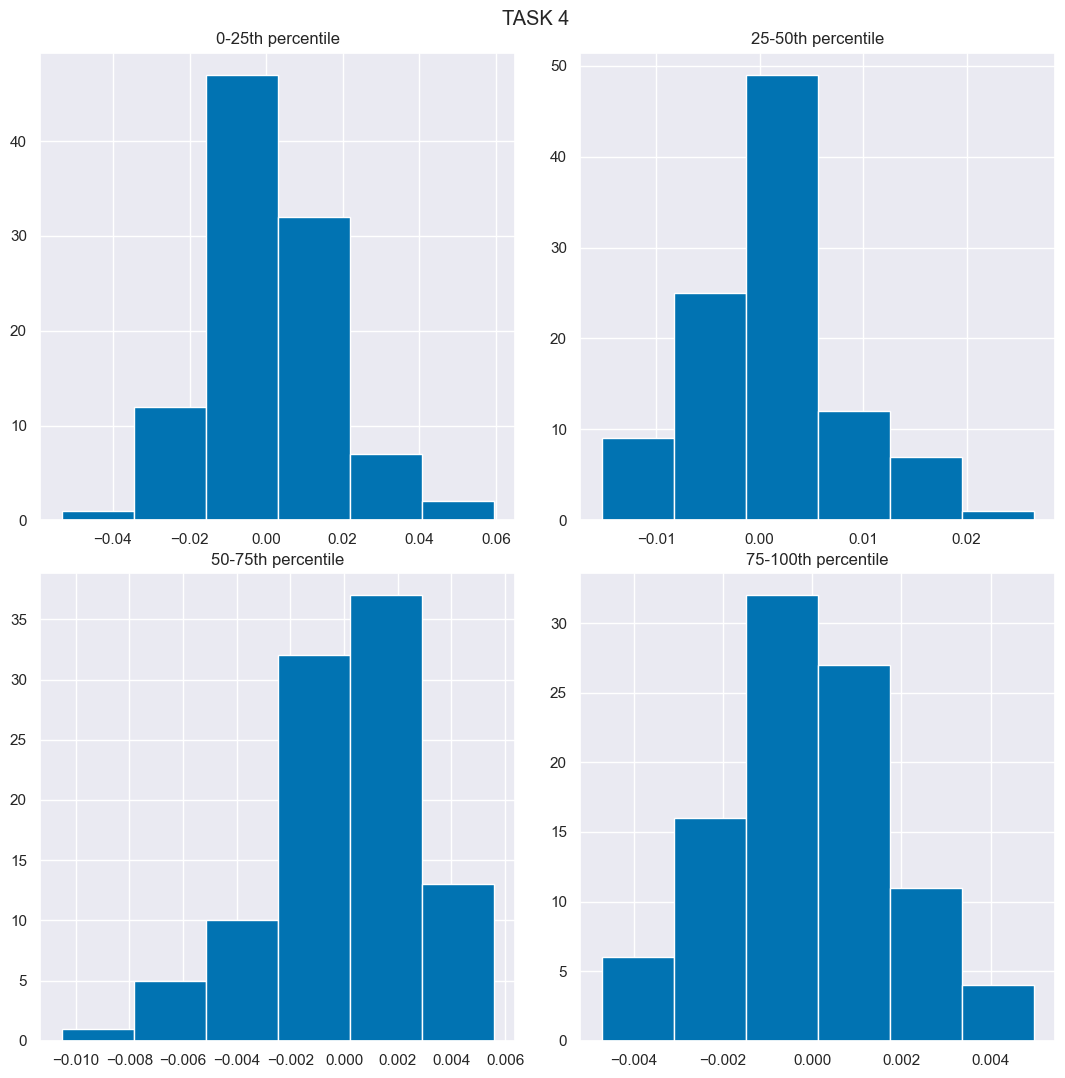

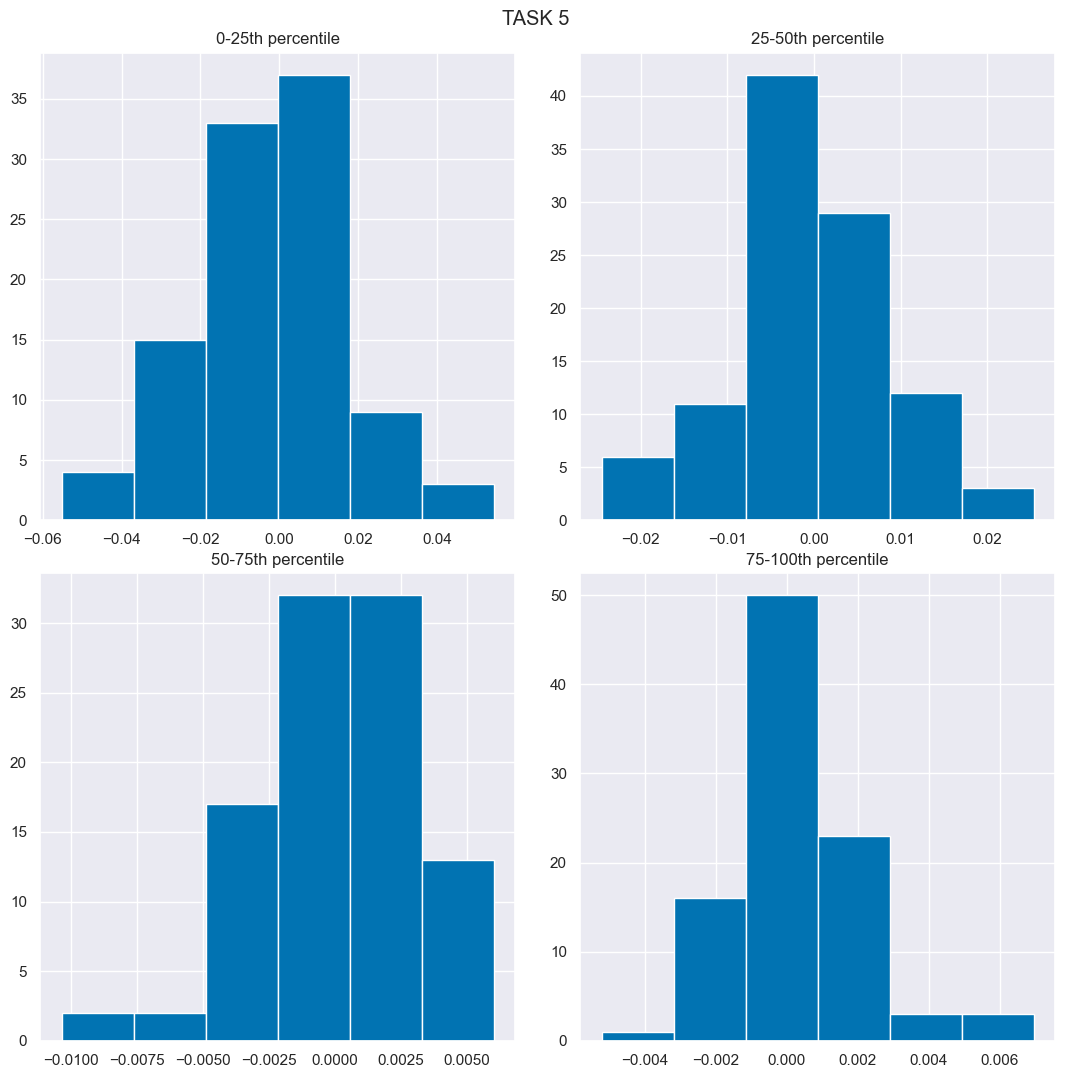

In [28]:
for i in range(len(quartile_dfs)):
    fig, axs = plt.subplots(2,2)
    name = 'TASK ' + str(i+1)
    fig.suptitle(name)
    fig.tight_layout(pad = 1.2)
    axs[0,0].hist(quartile_dfs[i][0]['offset_log'],bins = 6)
    axs[0,0].set_title('0-25th percentile')
    #axs[0,0].set_xlim(-1,2.5)

    #axs[0,0].set_ylim(0,100)

    
    axs[0,1].hist(quartile_dfs[i][1]['offset_log'],bins = 6)
    axs[0,1].set_title('25-50th percentile')
    #axs[0,1].set_xlim(-1,2.5)
    #axs[0,1].set_ylim(0,100)



    
    axs[1,0].hist(quartile_dfs[i][2]['offset_log'],bins = 6)
    axs[1,0].set_title('50-75th percentile')
    #axs[1,0].set_xlim(-1,2.5)
    #axs[1,0].set_ylim(0,100)




    axs[1,1].hist(quartile_dfs[i][3]['offset_log'],bins = 6)
    axs[1,1].set_title('75-100th percentile')
    #axs[1,1].set_xlim(-1,2.5)
    #axs[1,1].set_ylim(0,100)
    plt.savefig(name + '_residuals.png')
    plt.show()

## Larger model with multiple independent variables - Model 3

In [29]:
def mrModel_big(df):
    
    model = sm.ols(formula="adj_tone_log ~ week + ref_tone_log + rated_quality + fatigue + trial_counter", data=df).fit()
    print(model.params)
    print(model.summary())
    f = statsmodels.api.qqplot(model.resid)
    plt.show()
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(model.resid, 20)
    ax.set_title(model_names[i])
    plt.show()
    
    #create basic scatterplot
    ax = plt.figure(figsize =(8,8))
    ax.supxlabel('adj_tone_log')
    ax.supylabel('ref_tone_log')
    ax.set_tight_layout(True)
    plt.plot(df['adj_tone_log'], df['ref_tone_log'], 'o')
    #obtain m (slope) and b(intercept) of linear regression line
    #m = reg.coef_
    #b = reg.intercept_
    m = 0
    for each in model.params[1:]:
        m = m + each
    b = model.params[0]
    

    #add linear regression line to scatterplot 
    plt.plot(df['adj_tone_log'], m*df['adj_tone_log']+b)
    plt.show()
    return model

---------
Task 1
---------
Intercept        0.451820
week            -0.049613
ref_tone_log     0.941351
rated_quality    0.049300
fatigue         -0.001304
trial_counter    0.009174
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1407.
Date:                Sun, 05 Nov 2023   Prob (F-statistic):          2.83e-248
Time:                        12:04:56   Log-Likelihood:                -108.23
No. Observations:                 399   AIC:                             228.5
Df Residuals:                     393   BIC:                             252.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
            

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


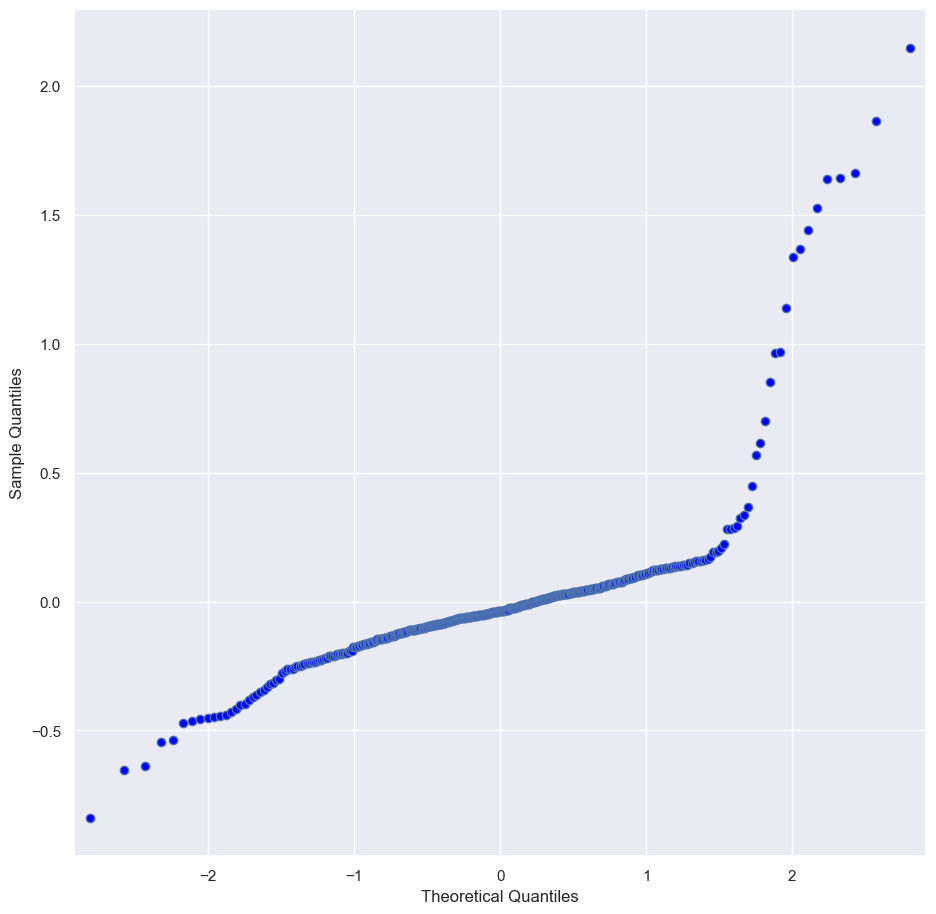

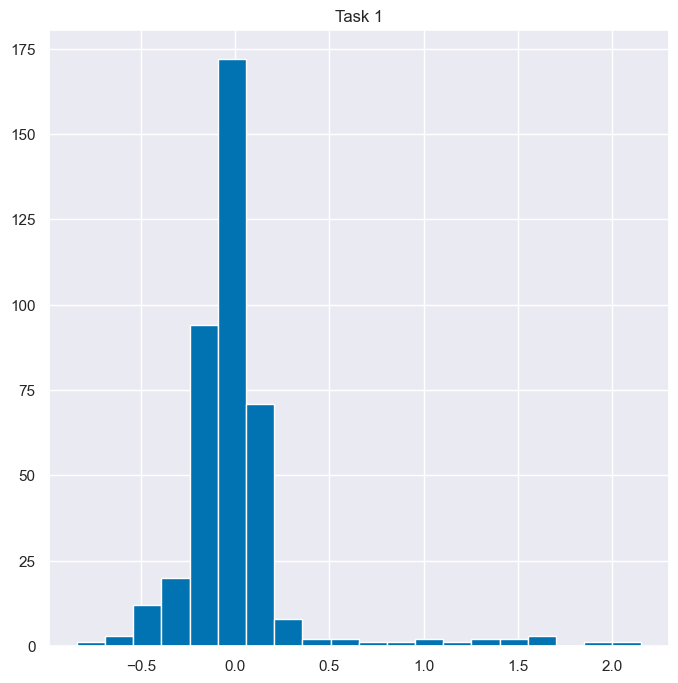

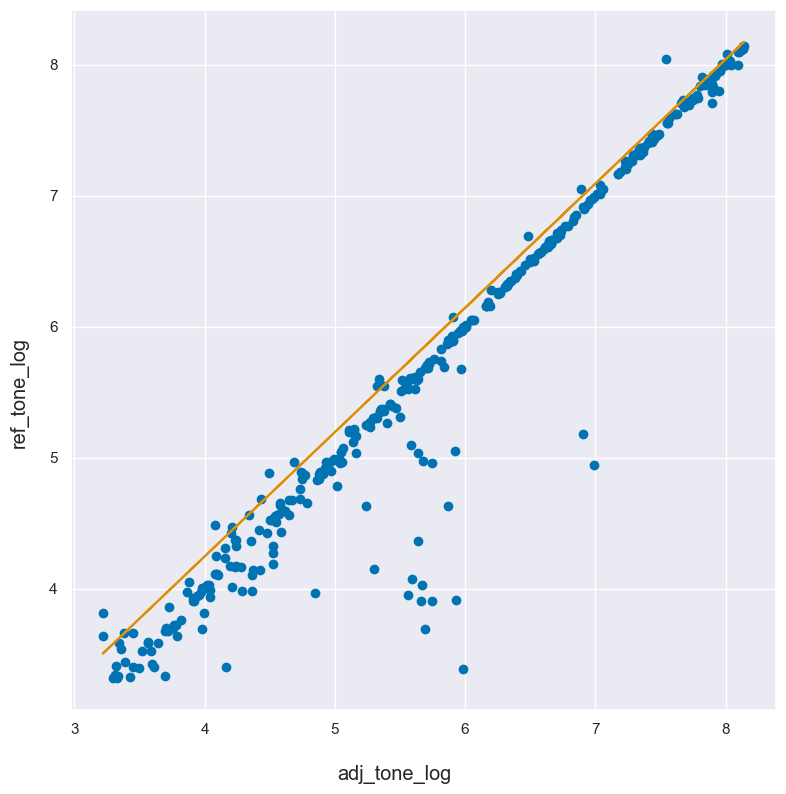

---------
Task 2
---------
Intercept        0.108750
week             0.008555
ref_tone_log     0.957121
rated_quality    0.013504
fatigue         -0.009530
trial_counter    0.030619
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     624.2
Date:                Sun, 05 Nov 2023   Prob (F-statistic):          1.36e-183
Time:                        12:04:57   Log-Likelihood:                -273.36
No. Observations:                 396   AIC:                             558.7
Df Residuals:                     390   BIC:                             582.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
            

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


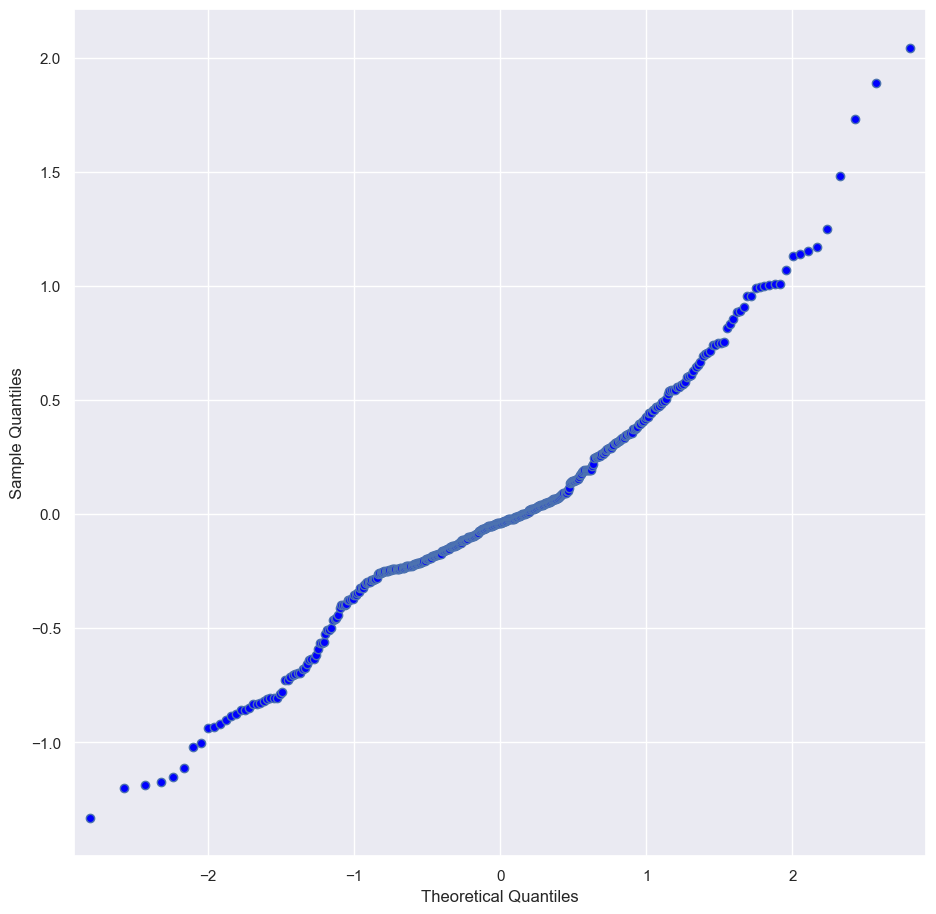

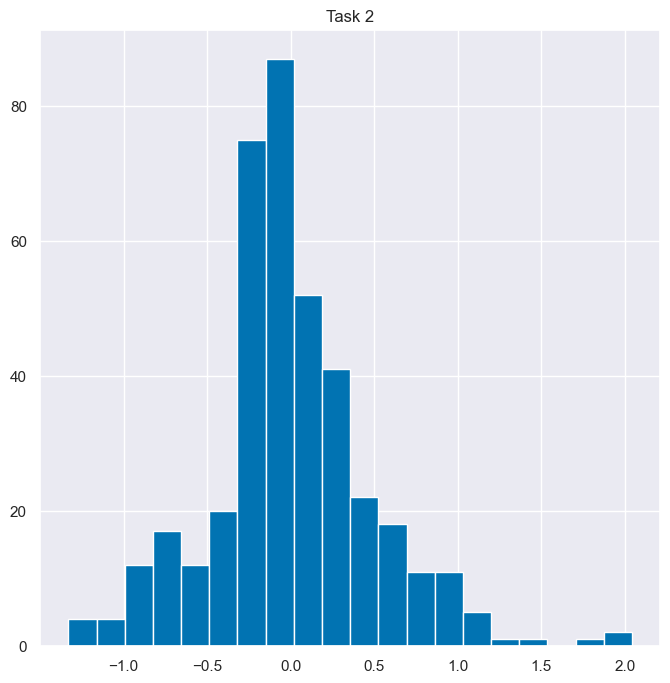

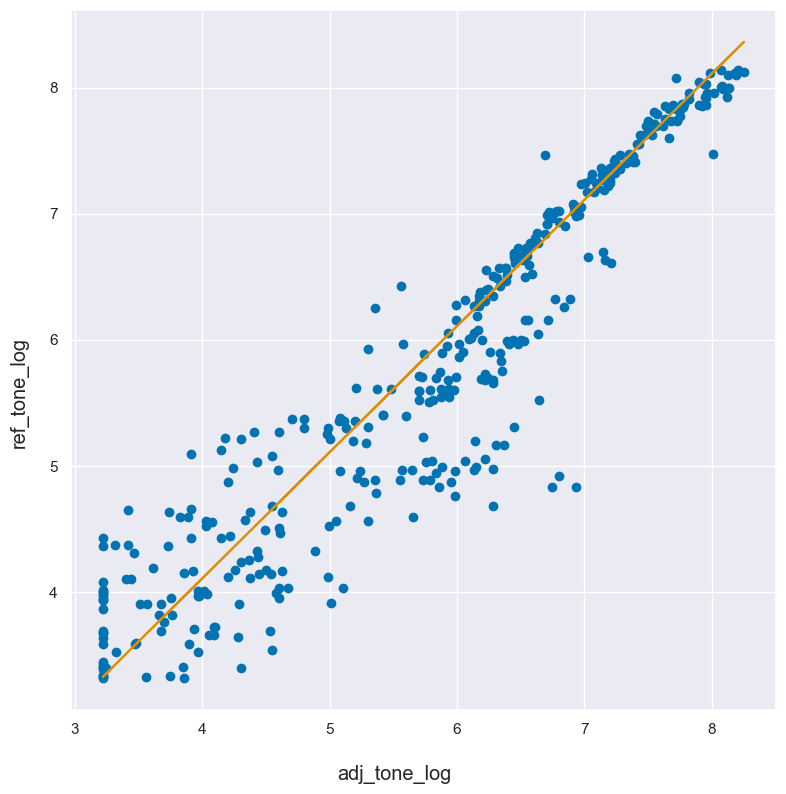

---------
Task 3
---------
Intercept        2.491261
week            -0.050867
ref_tone_log     0.658957
rated_quality   -0.023852
fatigue          0.011005
trial_counter    0.016190
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     229.0
Date:                Sun, 05 Nov 2023   Prob (F-statistic):          1.18e-106
Time:                        12:04:57   Log-Likelihood:                -269.34
No. Observations:                 347   AIC:                             550.7
Df Residuals:                     341   BIC:                             573.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
            

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


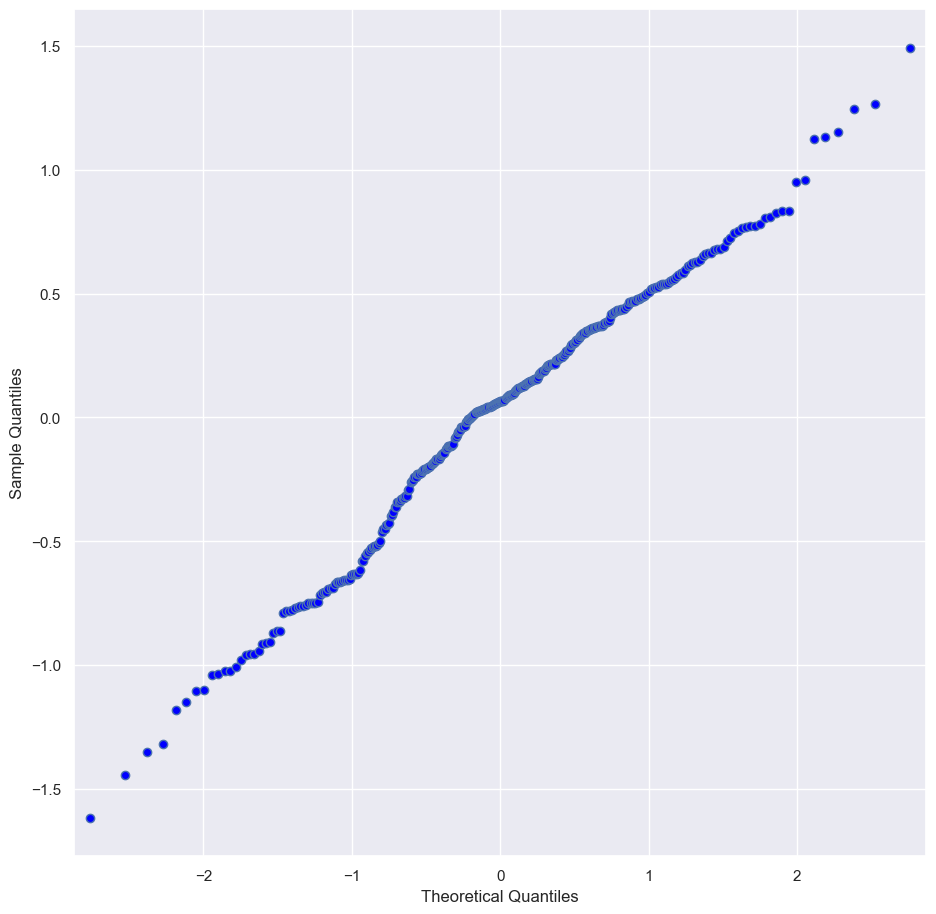

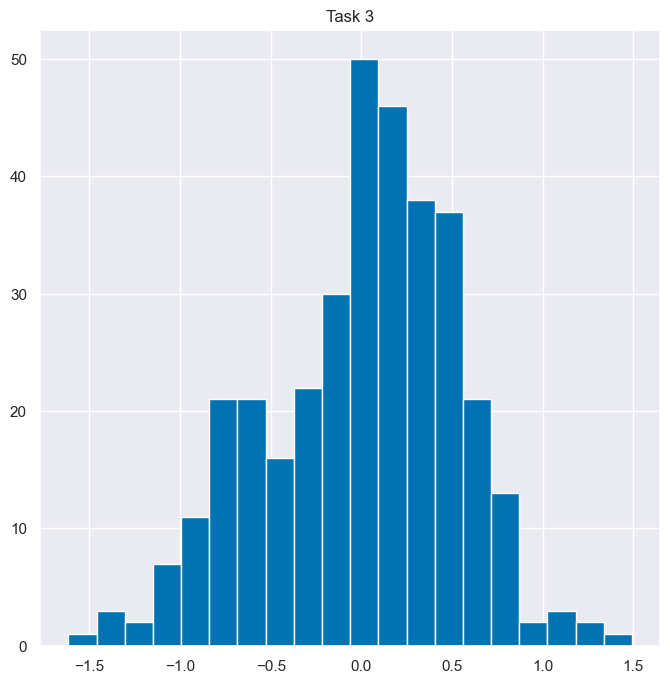

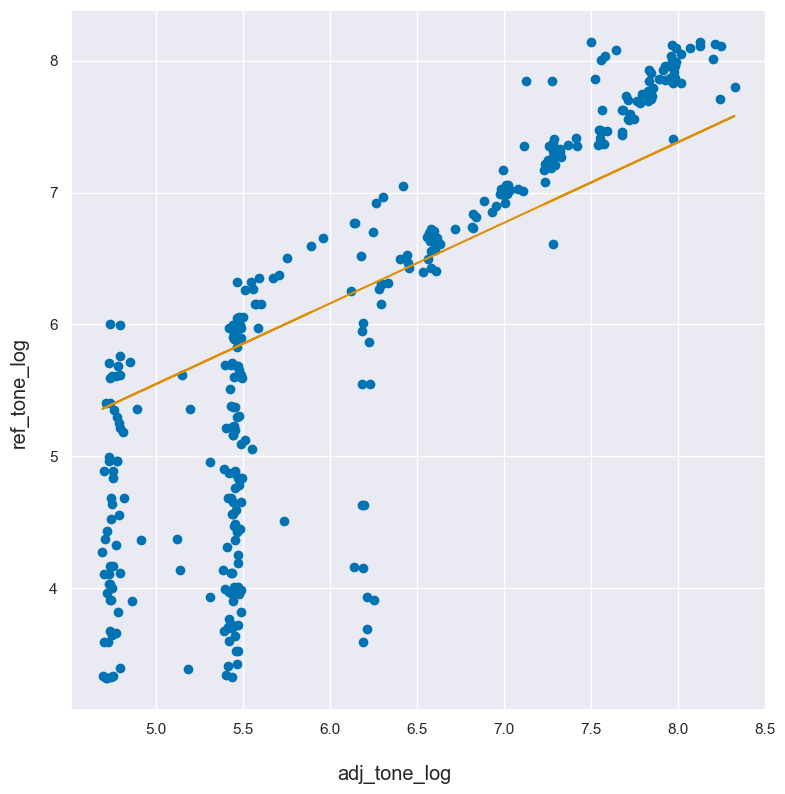

---------
Task 3 upper
---------
Intercept       -0.857374
week            -0.015004
ref_tone_log     1.116751
rated_quality    0.013796
fatigue          0.014336
trial_counter   -0.016388
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     190.7
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           2.59e-64
Time:                        12:04:58   Log-Likelihood:                -2.7080
No. Observations:                 161   AIC:                             17.42
Df Residuals:                     155   BIC:                             35.90
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
      

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


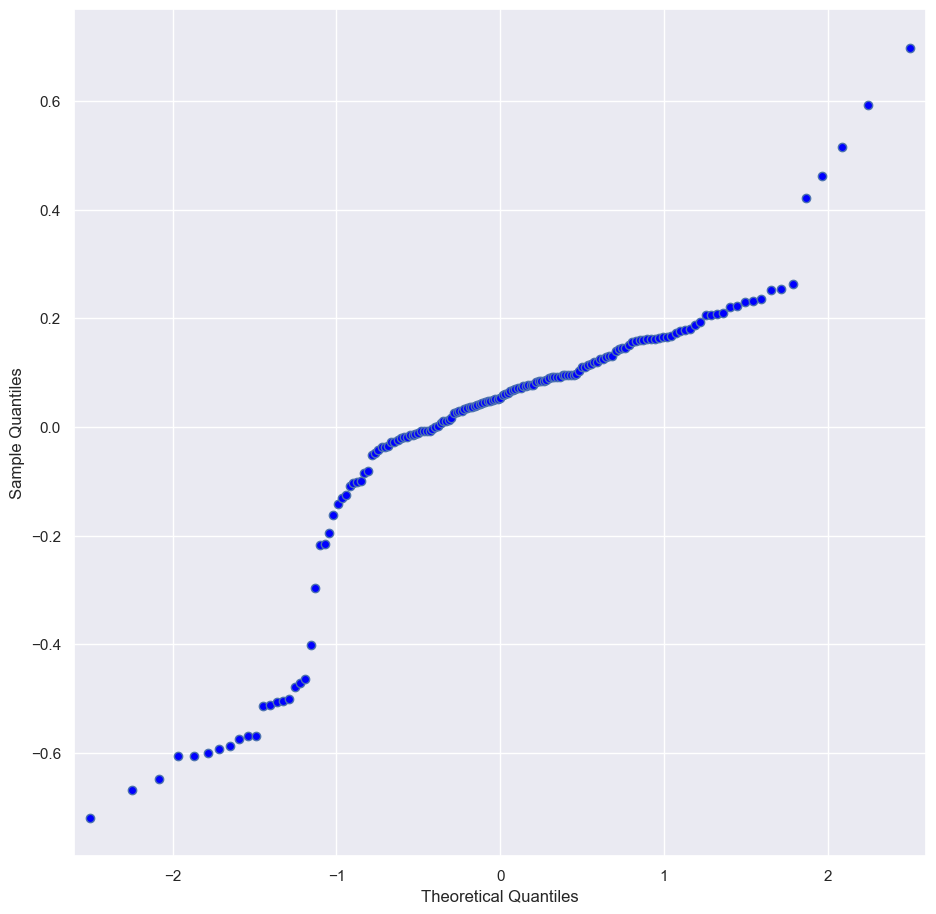

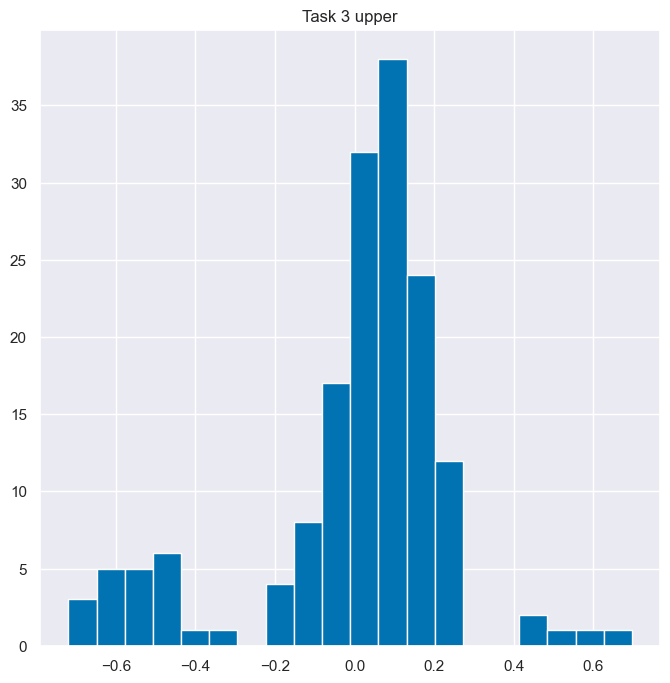

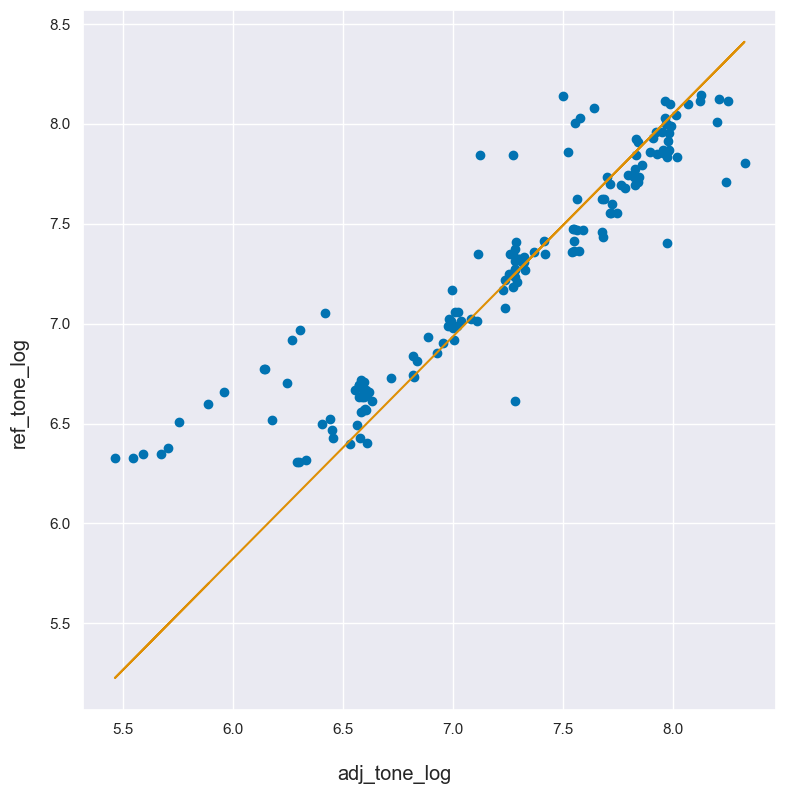

---------
Task 3 Lower
---------
Intercept        5.043441
week            -0.065984
ref_tone_log     0.114348
rated_quality   -0.025440
fatigue          0.025237
trial_counter    0.007057
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     8.861
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           1.54e-07
Time:                        12:04:58   Log-Likelihood:                -84.383
No. Observations:                 186   AIC:                             180.8
Df Residuals:                     180   BIC:                             200.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
      

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


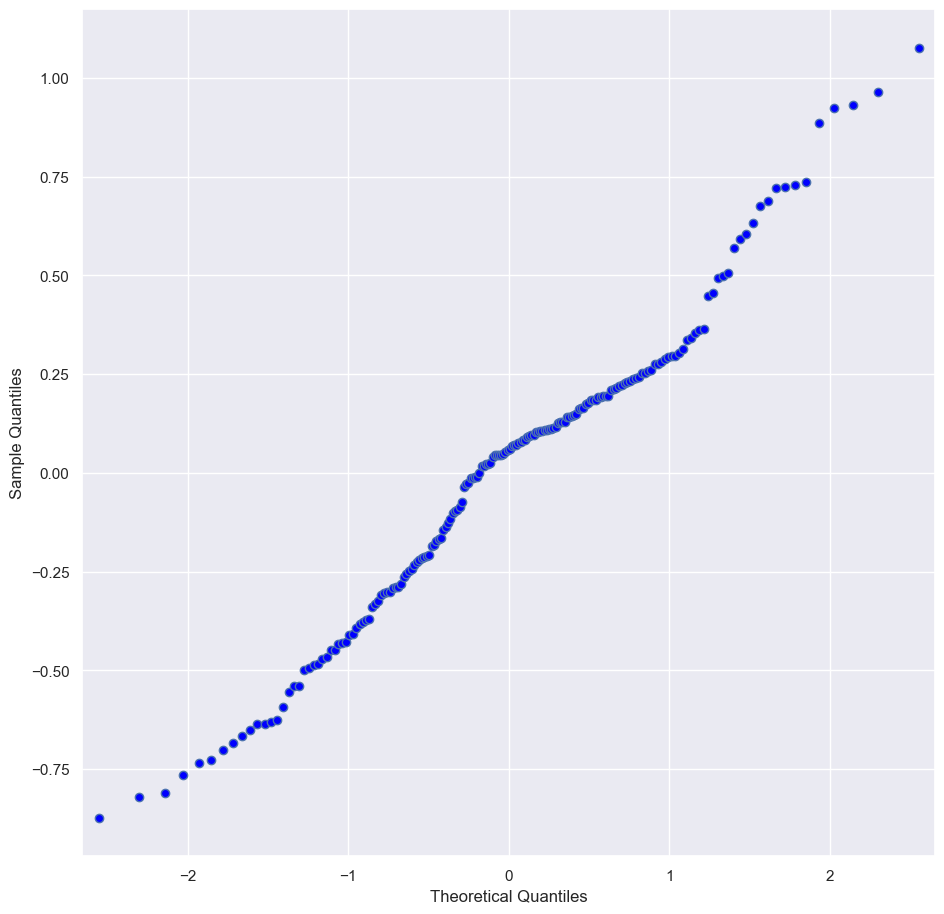

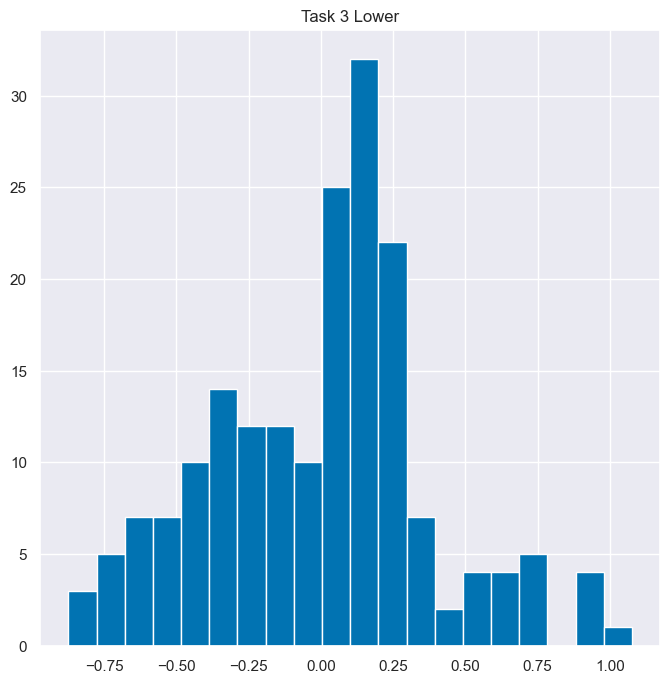

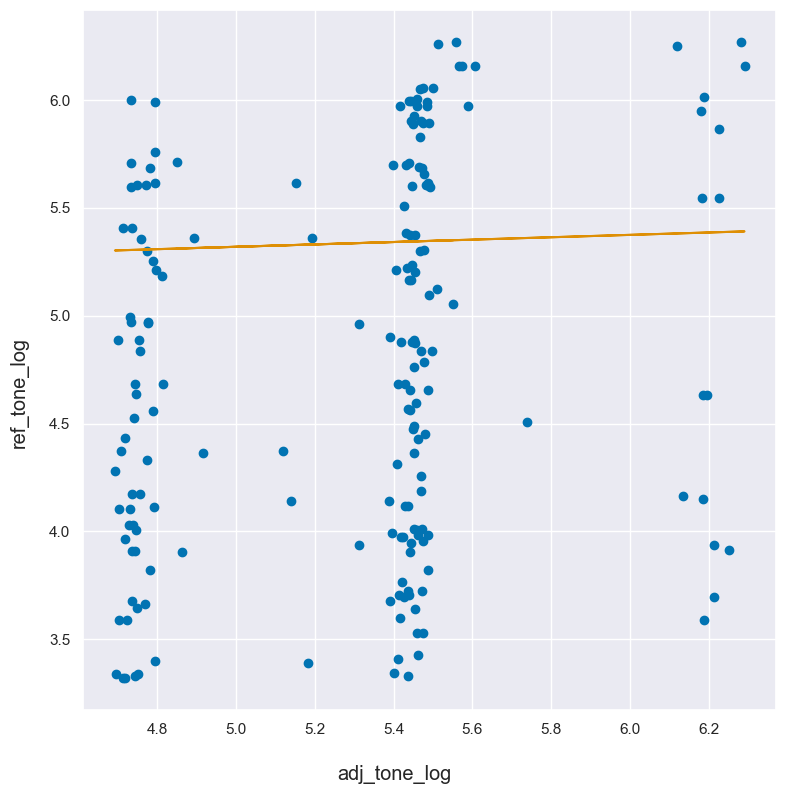

---------
Task 4
---------
Intercept        0.021187
week            -0.000213
ref_tone_log     0.999744
rated_quality   -0.004492
fatigue          0.000805
trial_counter    0.000321
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.706e+06
Date:                Sun, 05 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:04:59   Log-Likelihood:                 1286.3
No. Observations:                 399   AIC:                            -2561.
Df Residuals:                     393   BIC:                            -2537.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
            

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


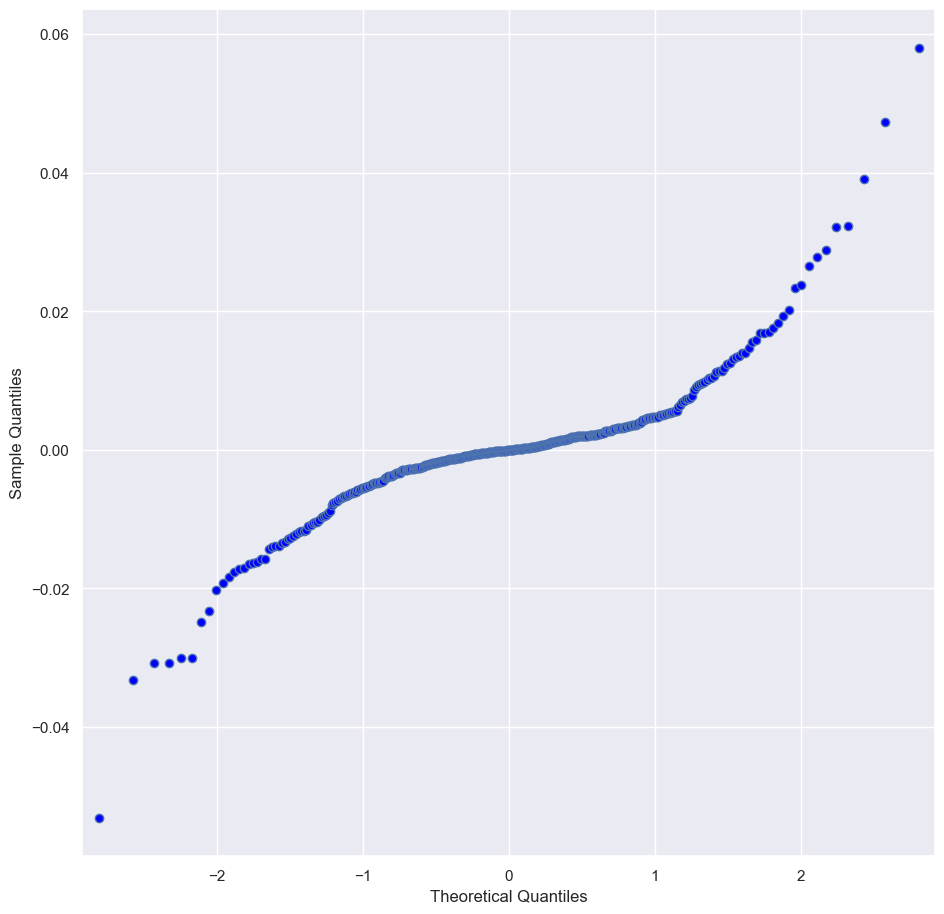

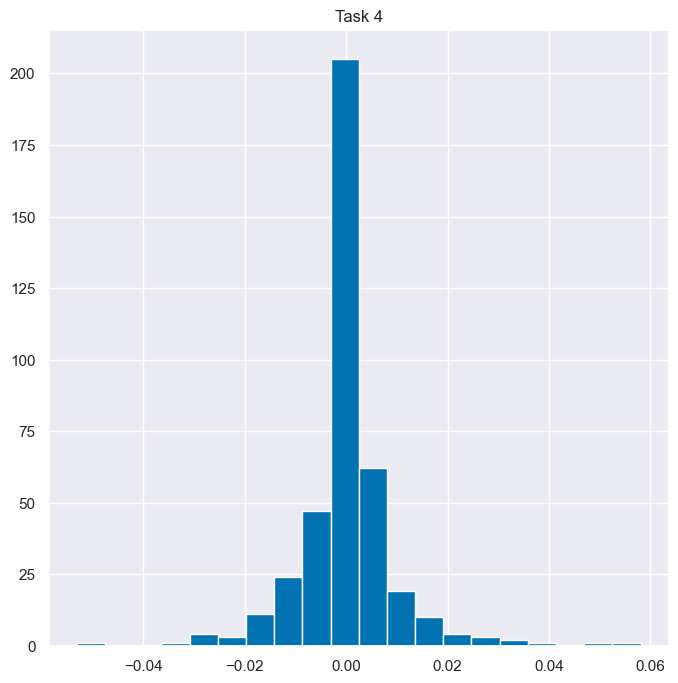

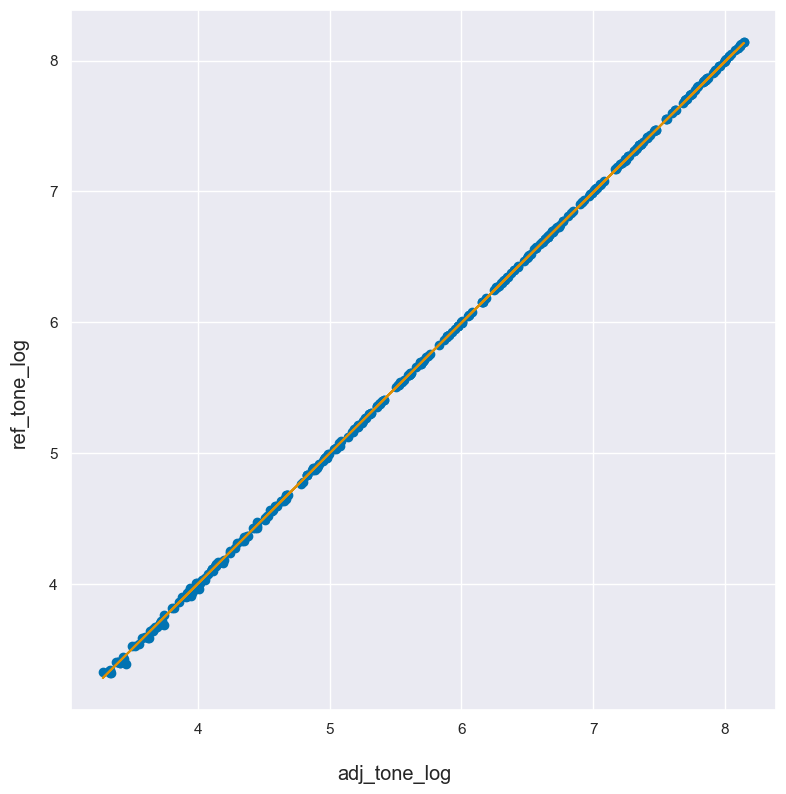

---------
Task 5
---------
Intercept       -0.034632
week            -0.000022
ref_tone_log     1.000484
rated_quality    0.006390
fatigue         -0.000038
trial_counter   -0.000086
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           adj_tone_log   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.455e+06
Date:                Sun, 05 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:05:00   Log-Likelihood:                 1254.2
No. Observations:                 399   AIC:                            -2496.
Df Residuals:                     393   BIC:                            -2472.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
            

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


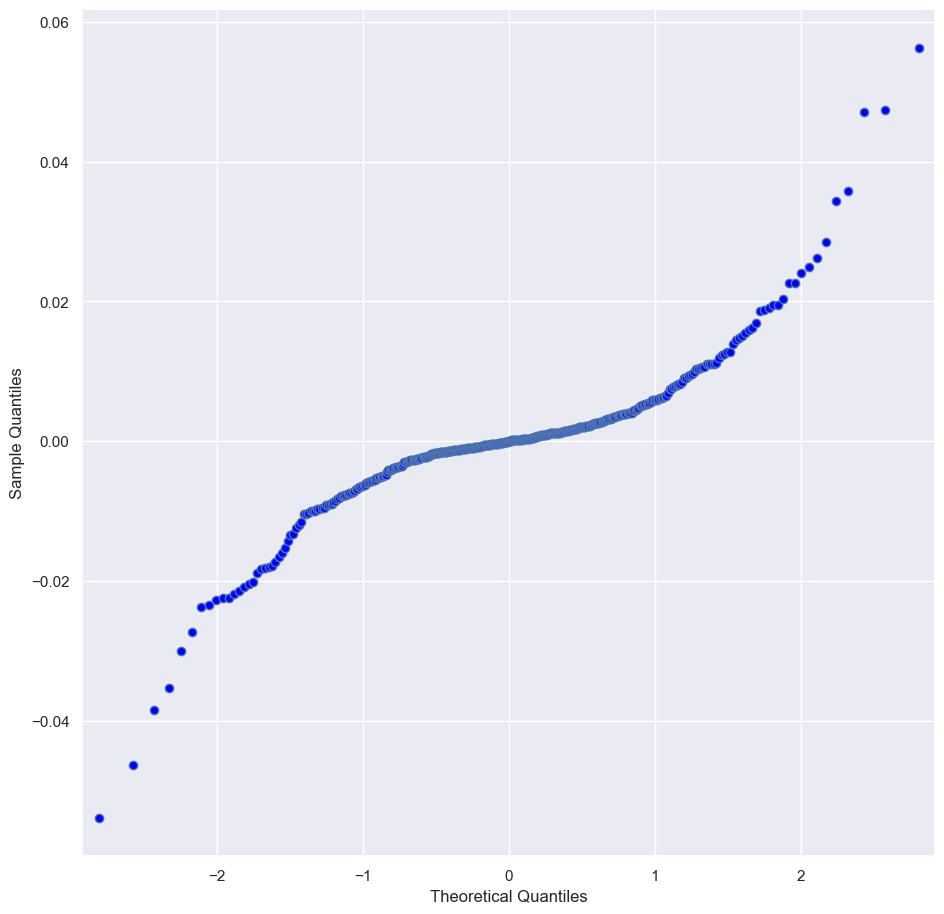

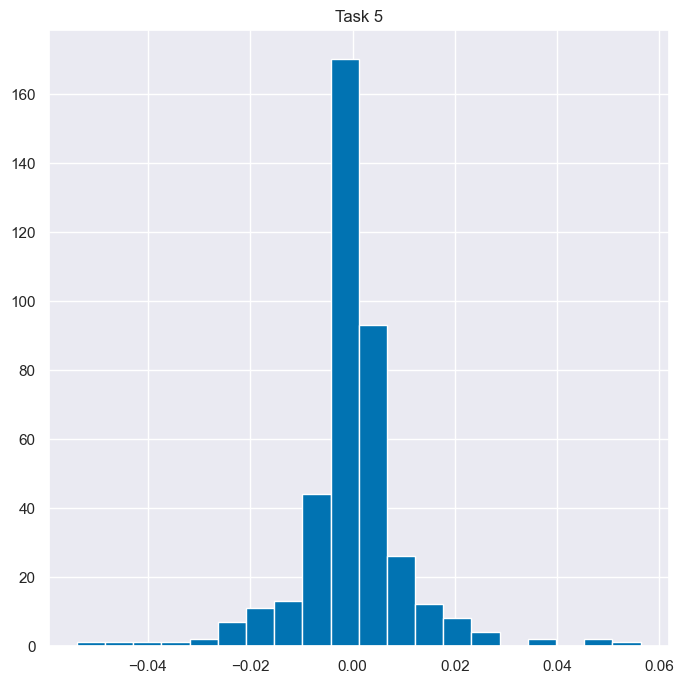

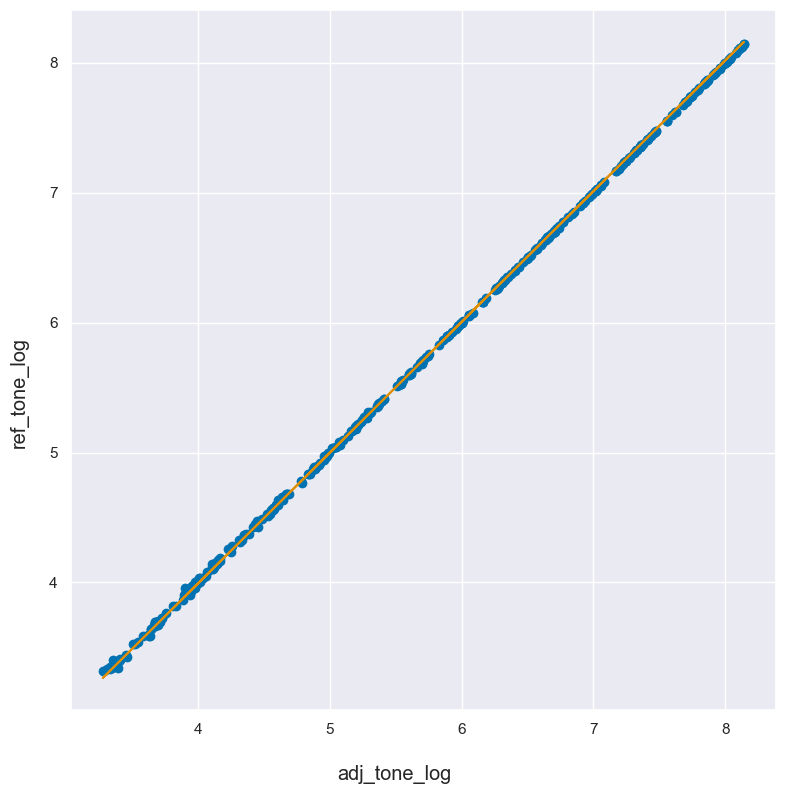

In [30]:
big_models = []
for i in range(len(models)):
    print('---------')
    print(model_names[i])
    print('---------')
    big_models.append(mrModel_big(models[i]))

### Investigate task 3 lower - our models think week is more important than reference tone?

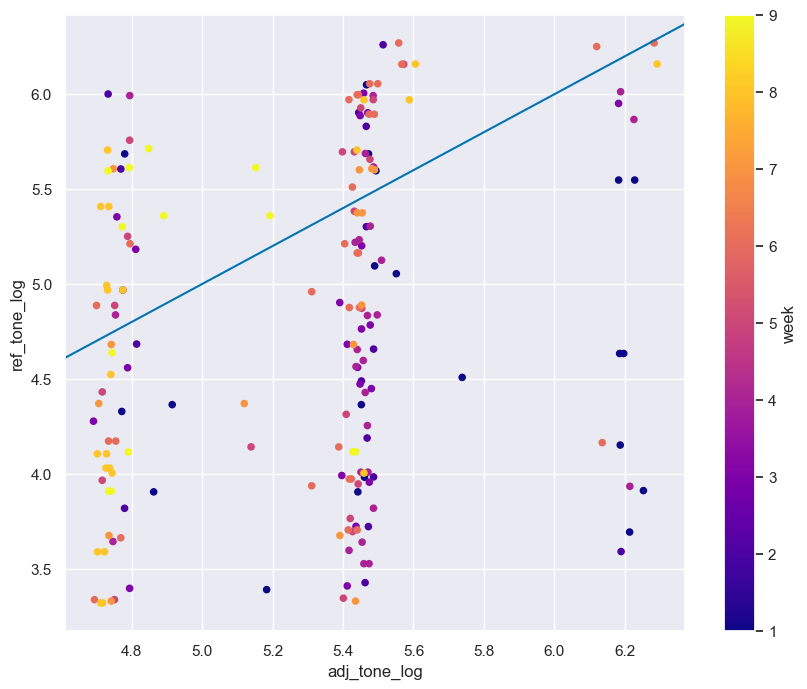

In [31]:
ax = task3_lower.plot.scatter(x='adj_tone_log',
                      y='ref_tone_log',
                      c='week',
                      colormap='plasma',
                   figsize = (10,8))
ax.axline([5,5],[6,6])
plt.show()

## Plot making section - creates aggregated graphs for the report

In [32]:
def qqplots(models, filename):
        

    # Sample data in a NumPy array (you can replace this with your own data)
    data = np.random.rand(7, 100)  # 7 subplots with 100 data points each

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(6, 10))

    # Flatten the axes array for easy iteration
    axes = axes.ravel()

    # Customize and plot each subplot
    for i in range(len(models)):
        ax = axes[i]
        statsmodels.api.qqplot(models[i].resid, ax=ax)
        ax.set_title(model_names[i])
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
    # Remove any unused subplots
    for i in range(7, 8):
        fig.delaxes(axes[i])

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.savefig(filename)
    # Show the plot or save it to a file (e.g., plt.savefig("output.png"))
    plt.show()


C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt str

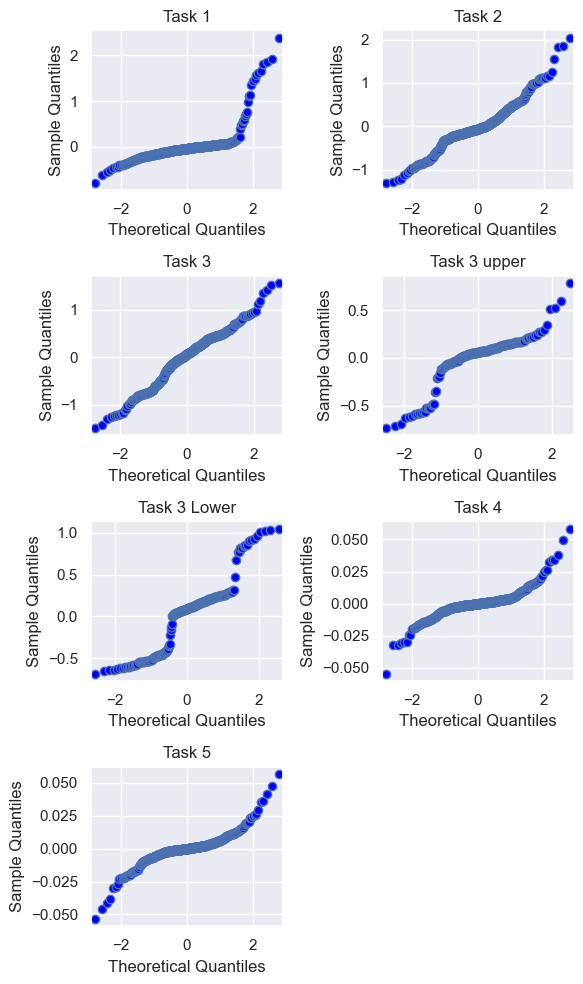

In [33]:
qqplots(reg_models, 'reg_models.png')

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt str

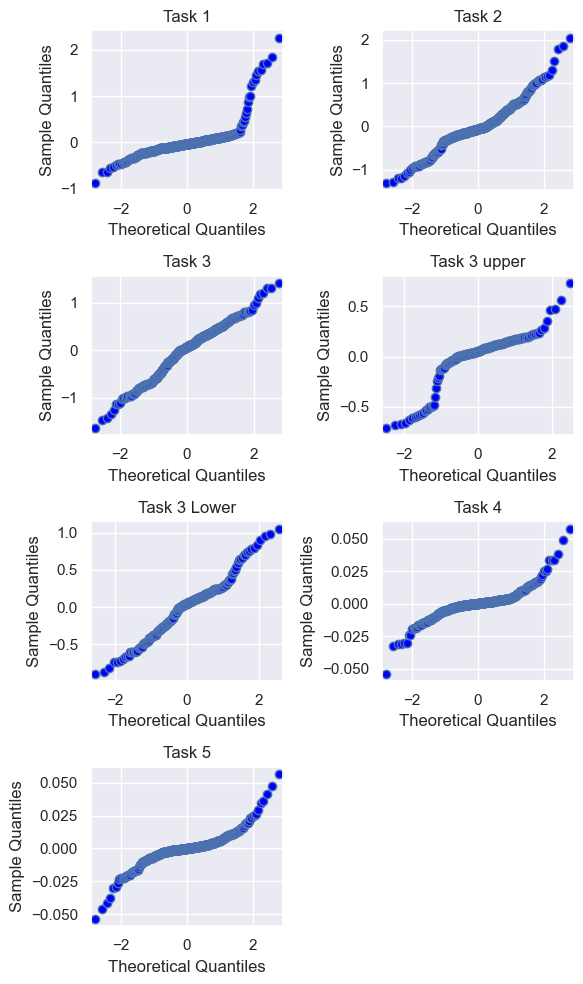

In [34]:
qqplots(mr_models, 'mr_models.png')

C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\morto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt str

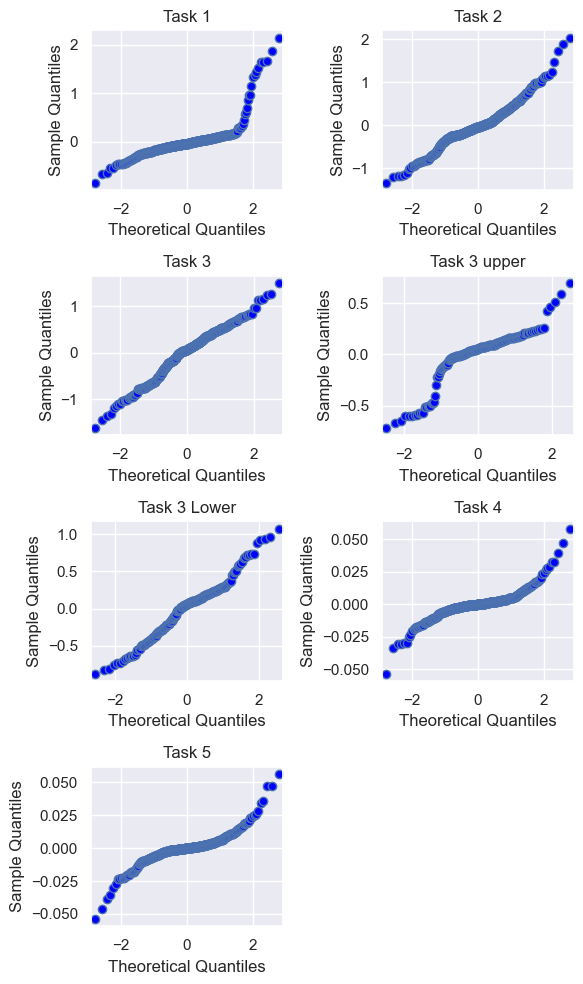

In [35]:
qqplots(big_models, 'big_models.png')

## residual distributions

In [36]:
def displots(models, filename):
        

    # Sample data in a NumPy array (you can replace this with your own data)
    data = np.random.rand(7, 100)  # 7 subplots with 100 data points each

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(6, 10))

    # Flatten the axes array for easy iteration
    axes = axes.ravel()

    # Customize and plot each subplot
    for i in range(len(models)):
        ax = axes[i]
        ax.hist(models[i].resid, 20)
        ax.set_title(model_names[i])
    # Remove any unused subplots
    for i in range(7, 8):
        fig.delaxes(axes[i])

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.savefig(filename)
    # Show the plot or save it to a file (e.g., plt.savefig("output.png"))
    plt.show()

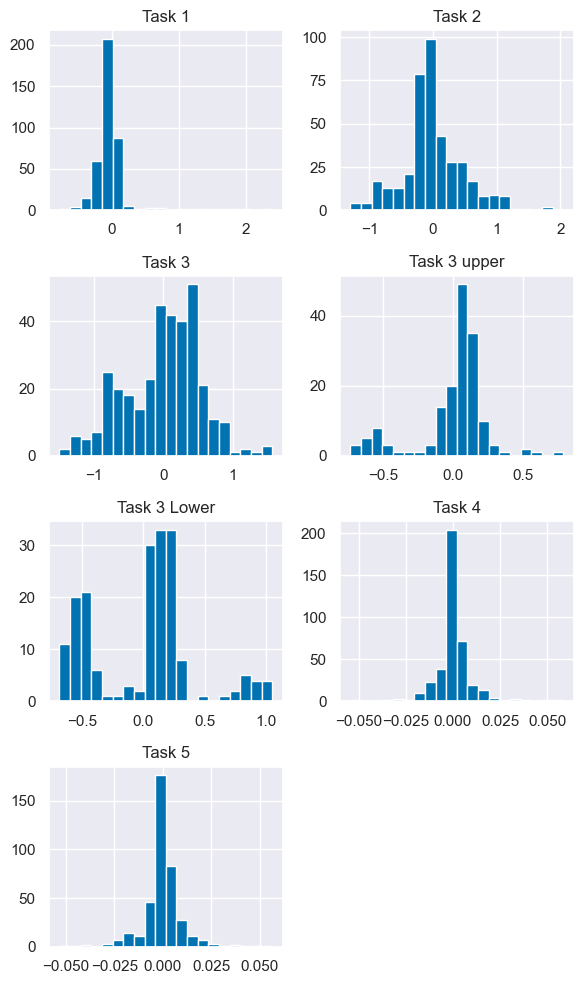

In [37]:
displots(reg_models, 'reg_models_disp.png')

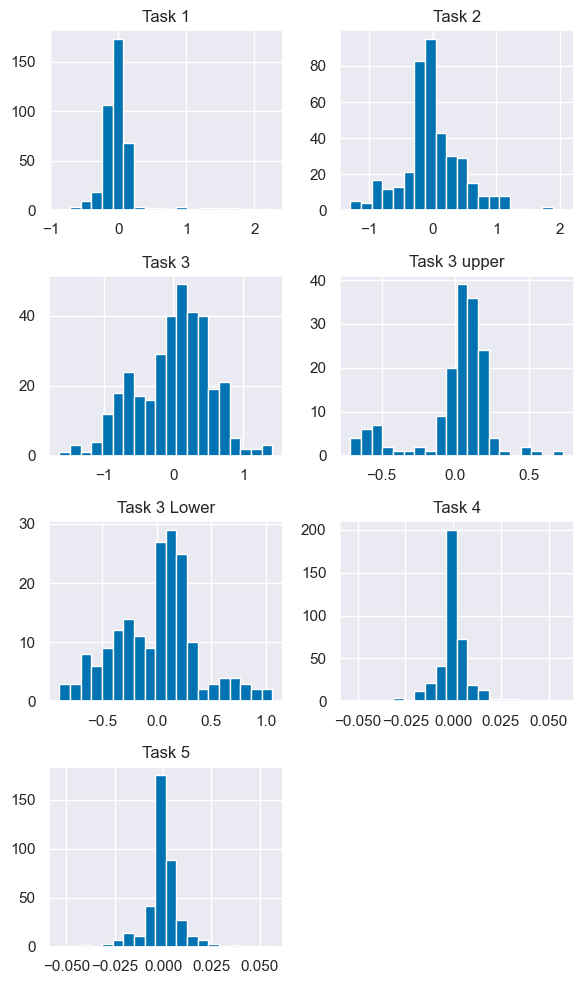

In [38]:
displots(mr_models, 'mr_models_disp.png')

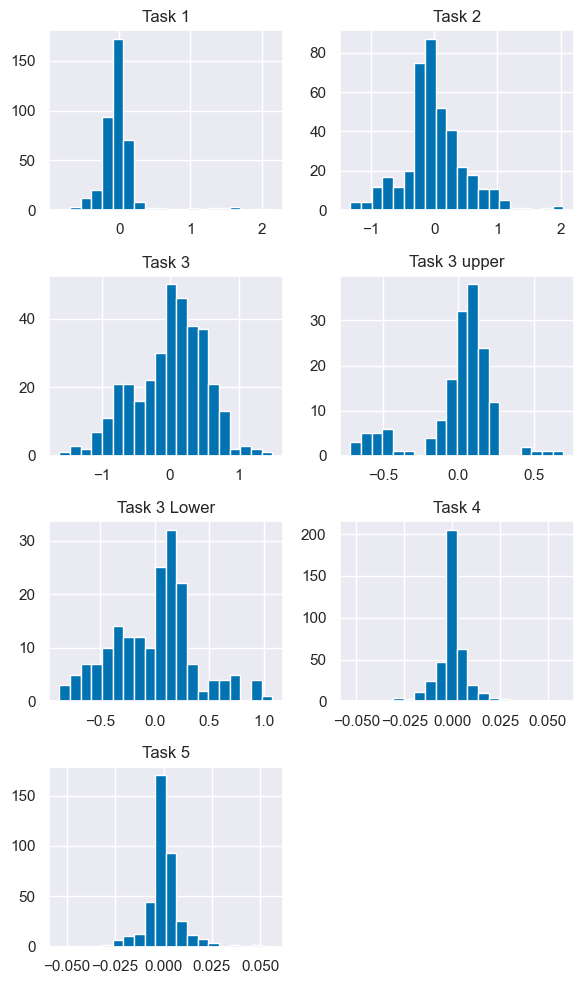

In [39]:
displots(big_models, 'big_models_disp.png')